# 1. Introdução

## 1.1.	Contextualização

Redes sociais possuem uma relevância cada vez maior no quotidiano das pessoas e permitem uma troca diária de bilhões de mensagens. Em meio a essa troca, pessoas expressam opiniões sobre os serviços oferecidos por empresas e instituições, seja ao se comunicar com essas entidades, seja ao fazer comentários sobre elas para outras pessoas.
Monitorar tais opiniões pode ter grande valor para qualquer entidade que queira melhorar seus serviços. Dado o volume em questão, é impossível fazer isso manualmente e, como as mensagens são escritas em linguagem natural, automatizações tradicionais podem não funcionar muito bem. Isso cria um excelente cenário para aplicação de inteligência artificial.

## 1.2. O problema proposto

Nesse trabalho atacamos o problema de classificar mensagens enviadas à Receita Federal do Brasil através da rede social Twitter como positivas ou negativas, deixando a realização de análises mais detalhadas e a exploração de outras redes sociais para trabalhos futuros. Para essa classificação, serão utilizados apenas mensagens do Twitter disponíveis publicamente, que fazem menção à entidade Receita Federal do Brasil e tenham sido enviadas desde a criação da conta da entidade na rede social, no início de 2009 até meados de março de 2021.


In [ ]:
# seed utilizado para conseguir replicar os resultados
random_state = 0

# 2. Coleta de Dados

Para a realização desse trabalho, foi criado um dataset específico do problema alvo extraído do Twitter e rotulado pelo autor e utilizados alguns datasets de problemas semelhantes obtidos da internet já com rotulação.

In [ ]:

# Preparação do ambiente com os datasets, arquivos e modelos utilizados

if 'google.colab' in str(get_ipython()):
  # Copia todos os datasets utilizados
  !mkdir datasets
  !cp "drive/My Drive/00 - TCC - Thiago Morello/datasets/datasets_kaggle.zip" datasets
  !cp "drive/My Drive/00 - TCC - Thiago Morello/datasets/balanced_df.zip" datasets
  !cp "drive/My Drive/00 - TCC - Thiago Morello/datasets/tweets_classificados_rfb.csv" datasets/tweets_classificados_rfb.csv
  !cp "drive/My Drive/00 - TCC - Thiago Morello/datasets/tweets_rfb.json" datasets/tweets_rfb.json

  # Copia os arquivos utilizados
  !mkdir files
  !cp "drive/MyDrive/00 - TCC - Thiago Morello/files/Symbola.otf" files/Symbola.otf

  # Copia os modelos gerados
  !mkdir models
  !cp -r "drive/MyDrive/00 - TCC - Thiago Morello/models" .


# Extrai os datasets do formato zip
!unzip -o datasets/datasets_kaggle.zip -d datasets
!unzip -o datasets/balanced_df.zip -d datasets

# Atualiza o spacy para a versão mais recente
!pip install spacy --upgrade

mkdir: cannot create directory ‘datasets’: File exists
mkdir: cannot create directory ‘files’: File exists
mkdir: cannot create directory ‘models’: File exists
Archive:  datasets/datasets_kaggle.zip
  inflating: datasets/imdb-reviews-pt-br.csv  
  inflating: datasets/NoThemeTweets.csv  
  inflating: datasets/TweetsWithTheme.csv  
  inflating: datasets/Tweets_Mg.csv  
Archive:  datasets/balanced_df.zip
  inflating: datasets/balanced_df.json  
Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.5)


In [ ]:
import pandas as pd
import joblib, pickle

## 2.1. Datasets obtidos do site Kaggle

Os três datasets extraídos da internet foram os seguintes:
-	“Tweets em português para análise de sentimentos”: acessado em 09/03/2021, através do link https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis 
-	“Tweets de MG/BR”: acessado em 09/03/2021, através do link https://www.kaggle.com/leandrodoze/tweets-from-mgbr 
-	“IMDB PT-BR”: acessado em 09/03/2021, através do link https://www.kaggle.com/luisfredgs/imdb-ptbr 

Do dataset “Tweets em português para análise de sentimentos” foram utilizados os arquivos “NoThemeTweets.csv”, que apresenta tweets sem temática definida, e “ThemedTweets.csv”, que apresenta tweets com tema definido pela pesquisa (coluna “query_used”). Para o dataset “Tweets de MG/BR”, foi utilizado o arquivo “Tweets_Mg.csv”, novamente no formato CSV. Nesse dataset havia diversas colunas vazias e sem título e, por isso, serão descartadas mais à frente. Já para o dataset “IMDB PT-BR”, foi obtido do arquivo “imdb-reviews-pt-br.csv”, em formato CSV.

In [ ]:
# Dataset Tweets em português para análise de sentimentos #1
tweets_pt_no_theme_df = pd.read_csv("datasets/NoThemeTweets.csv")

# Dataset Tweets em português para análise de sentimentos #2
tweets_pt_themed_df = pd.read_csv("datasets/TweetsWithTheme.csv")

# Dataset Tweets de MG/BR
tweets_mg_df = pd.read_csv("datasets/Tweets_Mg.csv")

# Dataset IMDB PT-BR
imdb_pt_df =  pd.read_csv("datasets/imdb-reviews-pt-br.csv")


## 2.2. Datasets gerados pelo autor

Foi utilizada uma conta de desenvolvedor acadêmica no Twitter para extrair, através de sua nova API, dados desde o início da criação da conta da Receita Federal do Brasil (RFB), sendo extraídas mensagens até 10/04/2021 (data da extração). 


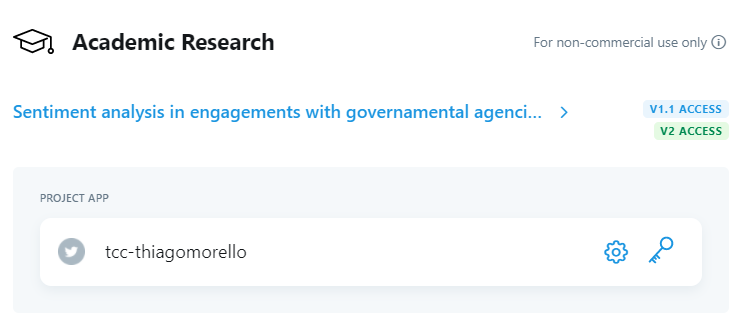

### 2.2.1. Código utilizado para gerar o dataset
Abaixo é apresentada uma pequena fração do código utilizado na extração, de autoria do próprio autor com base nos exemplos fornecidos na documentação da API do Twitter.
O código inclui um processo de anonimização usando um "salt" e algoritmo sha512.

In [ ]:
import requests
import json
import time
import hashlib
import uuid

# Cria o header com o o Token
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

# Conecta ao endpoint para chamda GET
def connect_to_endpoint(url, headers, params):
    response = requests.request("GET", url, headers=headers, params=params)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()

# Chama a API FULL SEARCH com os parâmetros fornecidos.
# e.g.: query = "to:receitafederal"
# next_token: Token da próxima página da pesquisa
# max_results: Número máximo de resultados por página
# end_time: Data e hora do tweet mais recente a retornar na pesquisa
def search_all(query, next_token=None, max_results=500, end_time=None):
  print("Calling twitter API FULL SEARCH with next_token '{}'".format(
      next_token
  ))
  url = "https://api.twitter.com/2/tweets/search/all"
  headers = create_headers(bearer_token)

  tweet_fields = "author_id,conversation_id,created_at," + \
                "geo,id,in_reply_to_user_id,lang,public_metrics," + \
                "referenced_tweets,text"
  params = {
      "query": query,
      "next_token": next_token,
      "max_results": max_results,
      "end_time": end_time,
      "start_time": "2006-03-21T00:00:00Z",
      "place.fields": "country,country_code,full_name,geo,id",
      "expansions": "geo.place_id",
      "tweet.fields": tweet_fields,
      "user.fields": "id,name,location,created_at"
  }
  return connect_to_endpoint(url, headers, params)

# Anonimiza as strings
def hash_string(string):
  if string is None:
    return None
  hash_object = hashlib.sha512(salt.encode() + string.encode())
  hex_dig = hash_object.hexdigest()
  return hex_dig

# Simplifica o json retornado pela API e anonimiza alguns campos
def flatten_dict(x):
  return {
      "id": hash_string(x["id"]),
      "lang": x["lang"],
      "conversation_id": hash_string(x["conversation_id"]),
      "author_id": hash_string(x["author_id"]),
      "created_at": x["created_at"],
      "reply_count": x.get("public_metrics", {}).get("reply_count"),
      "retweet_count": x.get("public_metrics", {}).get("retweet_count"),
      "like_count": x.get("public_metrics", {}).get("like_count"),
      "quote_count": x.get("public_metrics", {}).get("quote_count"),
      "in_reply_to_user_id": hash_string(x.get("in_reply_to_user_id")),
      "text": x["text"]
  }

# Realiza chamadas paginadas à API do Twitter, respeitando as limitações da API
def batch_twitter_crawler(query):
  results = []
  control = {}
  next_call = True
  next_token = None

  while(next_call):
    twts = search_all(query, next_token = next_token, max_results=500)
    
    flatten = list(map(flatten_dict , twts["data"]))
    
    results = results + flatten

    if "next_token" in twts["meta"]:
      control["next_token"] = twts["meta"]["next_token"]
    else:
      control["next_token"] = None

    next_token = control["next_token"]
    next_call = next_token
    
    # Espera 2 segundos antes da próxima chamada (rate limit: 1 req/s)
    time.sleep(2)
  return results

Caso se deseje testar a API com seu próprio token de acesso, basta comentar a linha "*%%script false*".

In [ ]:
# Desabilita a chamada dessa célula. 
# COMENTE A LINHA A SEGUIR PARA EXECUTAR ESTA CÉLULA
%%script false

# salt a se utilizar na anonimização
salt = uuid.uuid4().hex

# para reproduzir os resultados e permitir o join entre os datasets baixado
# pela API e classificado pelo autor, utiliza-se o salt abaixo:
salt = "7e041bf8a55041a1a16a9bcc9a29b8dc"

import getpass
print("Informe o token de acesso à API do Twitter:")
bearer_token= getpass.getpass()

# Busca todos os tweets enviados mencionando @ReceitaFederal ou 
# algum nome antigo usado pela conta
results = batch_twitter_crawler("to:receitafederal")

# Grava o resultado para arquivo
with open("datasets/tweets_rfb.json", "w") as f:
    f.write(json.dumps(results))

### 2.2.2. Resultado Final e classificação manual de sentimentos

Desse conjunto de dados obtidos pela API do Twitter, extraíram-se aleatoriamente 1038 mensagens para classificação manual, resultando no arquivo “tweets_classificados_rfb.csv”, em formato CSV, relacionado ao dataset anterior pela coluna “id”. Esses datasets serão chamados ao longo do trabalho de “tweets RFB” e “tweets classificados RFB”, respectivamente.

In [ ]:
# Dataset gerado a partir das chamadas à API
tweets_rfb_df = pd.read_json("datasets/tweets_rfb.json")

# Mensagens classificadas
tweets_rfb_classificados_df = pd.read_csv(
    "datasets/tweets_classificados_rfb.csv"
)

# 3. Processamento/Tratamento de Dados

Para o processamento e tratamento dos dados, foi utilizado Python, no Jupyter Notebook. Os datasets utilizados foram importados utilizando a biblioteca pandas, sendo importados cinco arquivos no formato CSV e um arquivo no formato JSON.

## 3.1. Análise dos datasets

Em seguida, trabalhou-se em cima desses arquivos, aplicando-se um método que retornasse quais os tipos das colunas, além da quantidade de registros, registros únicos, registros presentes e registros ausentes para cada um dos datasets.

In [ ]:
# Mostra os dados do tipo de coluna, total, registros únicos, 
# registros presentes e registros ausentes em um DataFrame
def show_columns_details(df):
  display(pd.DataFrame({
    "dtype": df.dtypes,
    "total": len(df),
    "unique": df.nunique(),
    "non-NA": df.count(),
    "NA": df.isna().sum()
  }))


Para os datasets "Tweets em português para análise de sentimentos" obteve-se o seguinte resultado:

In [ ]:
show_columns_details(tweets_pt_themed_df.append(tweets_pt_no_theme_df))
show_columns_details(tweets_pt_themed_df.append(tweets_pt_themed_df))

,dtype,total,unique,non-NA,NA
id,int64,847405,836066,847405,0
tweet_text,object,847405,826714,847405,0
tweet_date,object,847405,674767,847405,0
sentiment,object,847405,2,847405,0
query_used,object,847405,250,847405,0


,dtype,total,unique,non-NA,NA
id,int64,123182,61591,123182,0
tweet_text,object,123182,61283,123182,0
tweet_date,object,123182,60522,123182,0
sentiment,object,123182,2,123182,0
query_used,object,123182,248,123182,0


Para o dataset "Tweets de MG/BR", o resultado foi o seguinte:

In [ ]:
show_columns_details(tweets_mg_df) 

,dtype,total,unique,non-NA,NA
Unnamed: 0,int64,8199,8199,8199,0
Created At,object,8199,7945,8199,0
Text,object,8199,5765,8199,0
Geo Coordinates.latitude,float64,8199,57,104,8095
Geo Coordinates.longitude,float64,8199,57,104,8095
User Location,object,8199,1591,5489,2710
Username,object,8199,3907,8199,0
User Screen Name,object,8199,3966,8199,0
Retweet Count,int64,8199,113,8199,0
Classificacao,object,8199,3,8199,0


Já no dataset "IMDB-PT-BR", foram encontrados os seguintes resultados:

In [ ]:
show_columns_details(imdb_pt_df)

,dtype,total,unique,non-NA,NA
id,int64,49459,49459,49459,0
text_en,object,49459,49043,49459,0
text_pt,object,49459,49045,49459,0
sentiment,object,49459,2,49459,0


Por fim, para os datasets gerados pelo autor os detalhes são os seguintes:

In [ ]:
print("Tweets RFB:")
show_columns_details(tweets_rfb_df)
print("\n\nTweets RFB Classificados:")
show_columns_details(tweets_rfb_classificados_df)

Tweets RFB:


,dtype,total,unique,non-NA,NA
id,object,12688,12688,12688,0
lang,object,12688,20,12688,0
conversation_id,object,12688,9761,12688,0
author_id,object,12688,7489,12688,0
created_at,"datetime64[ns, UTC]",12688,12668,12688,0
reply_count,int64,12688,10,12688,0
retweet_count,int64,12688,22,12688,0
like_count,int64,12688,45,12688,0
quote_count,int64,12688,7,12688,0
in_reply_to_user_id,object,12688,1,12659,29




Tweets RFB Classificados:


,dtype,total,unique,non-NA,NA
id,object,1038,1038,1038,0
sentiment,int64,1038,2,1038,0


Observa-se que foram classificados 1038 de 12688 tweets, o que corresponde a 8,18% dos tweets coletados. Como os tweets foram escolhidos aleatoriamente para classificação, espera-se que tenham boa representatividade do dataset completo. 

Os dois arquivos provenientes dos dados de Tweets enviados a RFB foram unidos utilizando o método merge do pandas fazendo uma junção pela coluna “id”. Dessa forma, apenas os “tweets classificados RFB” serão utilizados na criação e teste dos modelos de aprendizado de máquina.

In [ ]:
# junta os datasets com a classificação ao seu texto de origem
tweets_rfb_classificados_df = tweets_rfb_classificados_df.merge(
    tweets_rfb_df, on='id', how='inner'
)
# informa o dataset de origem
tweets_rfb_classificados_df["origin"] = "tweets_rfb"
tweets_rfb_classificados_df[["created_at", "text", "sentiment"]].head(5)

,created_at,text,sentiment
0,2017-12-30 19:23:37+00:00,@ReceitaFederal Aeroporto do Rio de Janeiro e...,0
1,2020-04-12 16:57:26+00:00,@ReceitaFederal @SF_Moro @MPF_PGR @JornalBSM @...,1
2,2018-04-30 22:53:39+00:00,"@ReceitaFederal ""contribuinte"" kkkkkkkk essa é...",0
3,2018-04-12 14:09:36+00:00,@ReceitaFederal Gostaria de saber como a recei...,0
4,2017-08-29 16:00:28+00:00,@ReceitaFederal ser a que o que eu devo como p...,0


## 3.2. Colunas utilizadas

Feito isso, observou-se que em geral os datasets apresentavam algumas colunas semelhantes, e outras que não possuíam similares entre os datasets. As colunas que não possuiam similares (ex: “User Location”, “author_id”, etc) foram retiradas da análise e mantiveram-se as colunas semelhantes, sendo copiadas para novas colunas com nomes iguais entre datasets, para, posteriormente, juntar os datasets:
-	texto do tweet ou da avaliação em português, copiado para a coluna “text”;
-	data de criação, convertida para datetime e copiada para a coluna “created_at” (o dataset “IMDB PT-BR” não possuía data, então se deixará esse atributo ausente nesse caso);
-	categorização do sentimento, copiada para a coluna “sentiment”.

Além disso, foi adicionada uma coluna “origin” para identificar a origem do dataset.




In [ ]:
# Gera colunas com o mesmo nome (created_at, text, origin, sentiment) 
# para todos os Datasets

# Como as colunas de data dos datasets está como objecto (string),
# transforma-se para datetime
tweets_pt_themed_df["created_at"] = pd.to_datetime(
    tweets_pt_themed_df["tweet_date"], utc=True
)
tweets_pt_themed_df["text"] = tweets_pt_themed_df["tweet_text"]
tweets_pt_themed_df["origin"] = "tweets_pt"
tweets_pt_no_theme_df["created_at"] = pd.to_datetime(
    tweets_pt_no_theme_df["tweet_date"], utc=True
)
tweets_pt_no_theme_df["text"] = tweets_pt_no_theme_df["tweet_text"]
tweets_pt_no_theme_df["origin"] = "tweets_pt"
tweets_mg_df["created_at"] = pd.to_datetime(
    tweets_mg_df["Created At"], utc=True
)
tweets_mg_df["text"] = tweets_mg_df["Text"]
tweets_mg_df["origin"] = "tweets_mg"
tweets_mg_df["sentiment"] = tweets_mg_df["Classificacao"]
imdb_pt_df["text"] = imdb_pt_df["text_pt"]
imdb_pt_df["origin"] = "imdb_pt"
# Gera uma coluna vazia para o dataset que não possui data
imdb_pt_df["created_at"] = None
# Força o tipo da coluna para datetime
imdb_pt_df = imdb_pt_df.astype({"created_at": "datetime64"})


In [ ]:
# Ignora as outras colunas
tweets_pt_themed_df = tweets_pt_themed_df[["created_at", "text", "origin", "sentiment"]]
tweets_pt_no_theme_df = tweets_pt_no_theme_df[["created_at", "text", "origin", "sentiment"]]
tweets_mg_df = tweets_mg_df[["created_at", "text", "origin", "sentiment"]]
imdb_pt_df = imdb_pt_df[["created_at", "text", "origin", "sentiment"]]
tweets_rfb_classificados_df = tweets_rfb_classificados_df[["created_at", "text", "origin", "sentiment"]]

## 3.3. Conversão da coluna "sentiment" para binário

Antes de se juntar os datasets, foi preciso converter as diversas formas de categorização para o mesmo formato. Como no total dos arquivos usados, apenas 0,27% categorizavam o sentimento em neutro, esses dados são descartados e se escolheu o formato binário, “0” se negativo e “1” se positivo, para padronização da categorização na coluna “sentiment_binary”.

In [ ]:
# Representatividade de valores neutros considerando todos os datasets:
print("Percentual de valores neutros em todos os datasets: {:.2f}%".format(
      tweets_mg_df.value_counts("sentiment")["Neutro"]/(
        len(tweets_mg_df) +
        len(tweets_rfb_classificados_df) + 
        len(imdb_pt_df) + 
        len(tweets_pt_themed_df) + 
        len(tweets_pt_no_theme_df)
      ) *100
))

Percentual de valores neutros em todos os datasets: 0.27%


In [ ]:
# Exclui os tweets neutros
tweets_mg_df = tweets_mg_df.drop(
    tweets_mg_df[tweets_mg_df["sentiment"] == "Neutro"].index
)

Agora verifica-se a forma como cada dataset classificou os sentimentos e converte-se para 0 se for negativo e 1 se for positivo

In [ ]:
tweets_mg_df.value_counts("sentiment")

sentiment
Positivo    3300
Negativo    2446
dtype: int64

In [ ]:
# mapeia a categorização de sentimentos para 0 ou 1
sentiment_map = {
    "Negativo": 0,
    "Positivo": 1
}
tweets_mg_df["sentiment_binary"] = tweets_mg_df['sentiment'].map(
    sentiment_map
).fillna(tweets_mg_df['sentiment'])


In [ ]:
tweets_pt_no_theme_df.value_counts("sentiment")

sentiment
Negativo    522707
Positivo    263107
dtype: int64

In [ ]:
# mapeia a categorização de sentimentos para 0 ou 1
sentiment_map = {
    "Negativo": 0,
    "Positivo": 1
}
tweets_pt_no_theme_df["sentiment_binary"] = tweets_pt_no_theme_df['sentiment'].map(sentiment_map).fillna(tweets_pt_no_theme_df['sentiment'])


In [ ]:
tweets_pt_themed_df.value_counts("sentiment")

sentiment
Positivo    32744
Negativo    28847
dtype: int64

In [ ]:
# mapeia a categorização de sentimentos para 0 ou 1
sentiment_map = {
    "Negativo": 0,
    "Positivo": 1
}
tweets_pt_themed_df["sentiment_binary"] = tweets_pt_themed_df['sentiment'].map(sentiment_map).fillna(tweets_pt_themed_df['sentiment'])


In [ ]:
imdb_pt_df.value_counts("sentiment")

sentiment
neg    24765
pos    24694
dtype: int64

In [ ]:
# mapeia a categorização de sentimentos para 0 ou 1
sentiment_map = {
    "neg": 0,
    "pos": 1
}
imdb_pt_df["sentiment_binary"] = imdb_pt_df['sentiment'].map(sentiment_map).fillna(imdb_pt_df['sentiment'])


In [ ]:
tweets_rfb_classificados_df.value_counts("sentiment")

sentiment
0    604
1    434
dtype: int64

In [ ]:
# como os tweets RFB já estão no padrão desejado, apenas cria-se a mesma
# coluna 'sentiment_binary' com os dados
tweets_rfb_classificados_df["sentiment_binary"] = tweets_rfb_classificados_df["sentiment"]

## 3.4. Junção dos datasets, remoção de valores duplicados e balanceamento

Com as colunas em comum apresentando o mesmo nome, foi possível juntar os diversos datasets utilizando o método append. Nesse passo ainda não foram incluídos os dados dos “tweets classificados RFB”, pois, com a intenção de não perder nenhum dado dessa classificação, esse dataset será incluído após o balanceamento do dataset gerado a partir da união dos datasets do Kaggle (dataset combinado).

In [ ]:
# junta os datasets, exceto o "Tweets classificados RFB"
total_df = tweets_pt_no_theme_df.append(
    tweets_pt_themed_df, ignore_index=True, sort=False
)
total_df = total_df.append(tweets_mg_df, ignore_index=True, sort=False)
total_df = total_df.append(imdb_pt_df, ignore_index=True, sort=False)


Uma das principais preocupações quando se trabalha com aprendizado de máquina é evitar a contaminação dos dados de teste com dados do conjunto de treinamento. Como será a partir dos textos desse dataset combinado que se extrairão as features utilizadas para os modelos de aprendizado de máquina, são eliminados os textos em duplicidade.

In [ ]:
tweets_rfb_classificados_df = tweets_rfb_classificados_df.drop_duplicates(subset ="text")
total_df = total_df.drop_duplicates(subset ="text")

print("Valores duplicados: {}".format(
    len(total_df) - total_df.nunique()["text"]
))

Valores duplicados: 0


Por fim, verifica-se se o dataset está balanceado:


In [ ]:
total_df.value_counts("sentiment_binary")

sentiment_binary
0    566448
1    313109
dtype: int64

O dataset combinado possuía sentimentos negativos em número diferente do de sentimentos positivos (566.448 classificados como negativo e 313.109 classificados como positivo). Esse dataset veio de problemas relacionados, mas não iguais ao problema alvo. Assim, não temos porque esperar que a proporção entre os sentimentos expressos seja igual ou mesmo parecida com a do problema alvo. Preferimos, então, balancear o conjunto e reduzir esse efeito.

In [ ]:
# Para o dataset desbalanceado agrupa-se pela coluna
# que se deseja balancear
grouped = total_df.groupby('sentiment_binary')
# Pega-se aleatoriamente de todos os grupos do agrupamento 
# em quantidade igual ao tamanho do menor grupo existente,
# resetando o índice
balanced_df = pd.DataFrame(
    grouped.apply(
        lambda x: x.sample(grouped.size().min(), random_state=random_state
).reset_index(drop=True))).reset_index(drop=True)

# Verifica-se se está balanceado
balanced_df['sentiment_binary'].value_counts()

1    313109
0    313109
Name: sentiment_binary, dtype: int64

Por fim, acrescentou-se o dataset de “tweets classificados RFB” gerando o dataset que será trabalhado nos passos seguintes.

In [ ]:
# Acrescenta os tweets enviados para a RFB
balanced_df = balanced_df.append(tweets_rfb_classificados_df)
# Embaralha-se o dataset
balanced_df = balanced_df.sample(frac=1, random_state=random_state)

In [ ]:
balanced_df = balanced_df.drop("sentiment", axis=1)

In [ ]:
balanced_df = balanced_df.astype({"created_at": "datetime64"})
show_columns_details(balanced_df)
balanced_df.sample(5, random_state=random_state)

,dtype,total,unique,non-NA,NA
created_at,datetime64[ns],627167,510209,589232,37935
text,object,627167,627167,627167,0
origin,object,627167,4,627167,0
sentiment_binary,int64,627167,2,627167,0


,created_at,text,origin,sentiment_binary
482771,2018-08-15 20:17:07,há gente mesmo gira e depois existo eu... um a...,tweets_pt,1
329373,2018-09-05 17:23:06,https://t.co/BfglLrD6ZH Venha se deliciar comi...,tweets_pt,1
368168,NaT,Eu me tornei um grande fã do trabalho de Barbe...,imdb_pt,1
281027,NaT,"Alguns podem zombar, mas há realmente uma arte...",imdb_pt,0
443813,2018-10-08 12:58:49,ha tem mais :) mas so muito grato a deus por t...,tweets_pt,1


# 4. Análise e exploração dos dados

Como esse trabalho tem como foco a classificação do sentimento observado em um determinado texto, são utilizadas diversas técnicas de processamento de linguagem natural (NLP) em conjunto com outras técnicas de manipulação de strings.

## 4.1. Análise de emojis


Percebe-se que o texto de internet costuma conter muitos emojis (pequenas imagens geralmente representadas por um ou dois caracteres na string. Como os emojis podem representar sentimentos antagônicos como raiva e alegria, choro ou risadas, é importante se manter os emojis para o processo de classificação. Para isso se levantaram quais os emojis mais utilizados, gerando um simples dicionário para traduzir esses emojis para palavras. O corpus utilizado nesse caso foi apenas do dataset “tweets RFB”, que é o foco do trabalho. Os códigos Unicode dos emojis foram consultados no site https://unicode.org/emoji/charts/full-emoji-list.html, acessado em 09/03/2021.



In [ ]:
import re

def get_emojis(text_array):
  text = "".join(text_array)
  text = re.sub(r'[\U00000000-\U000020FF\U0000FE0F]', "", text)
  text = re.sub(r'[\U0001F3FB-\U0001F3FF]', "", text) # remove skin tone
  text = re.sub(r'[\u2640\u2642]', "", text) # remove definição de gênero
  
  text = re.sub(r'[\r\n]', "", text)
  return re.sub(r'\s*', "", text)

# Pega os emojis da coluna "text" de todo o dataset RFB,
# incluso os tweets não clasificados
emojis = get_emojis(tweets_rfb_df["text"])
emojis

'🥺😭👇👇🧚🧚🧛🧛🧜🧜🧝🧝🧞🧞🧟🧟🤔👇👏👏👏👏😒👎🤧💔😭😭😭🙈🙉🙊😡😡😑😅❤😡😡😡😡🚨🤦🎥😭🖕🖕😡😭😭😭😭😭😭😭🥺😭👇⬇⬇🇧🇷🕵🖋😴😴😴☕🇧🇷🕵🖋🤔💥💥💥💥💥💥💥💥💣💣💣💣💣💥💥💣💲💲💲💣💥💥💣💲🐀💲💣💥💥💣💲💲💲💣💥💥💣💣💣💣💣💥💥💥💥💥💥💥💥⤵⤵⤵⤵⤵⤵🤔🤔🤔🎯☑👇💸💰💰😢🤦😭😭😭🥺👏👏👏📦🇧🇷👏🤡😋🍷🙏🇧🇷🇧🇷👍❓❓👇👇👇👇👇👇👇😂🔴🌑👀🚢🇧🇷⚓🇪🇸⚠⚠⚠⚠⚠⚠🏦🇧🇷🕵🖋🇧🇷🕵🖋😔🙏🎈🎈👏👏👏🤬🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷👏👏👏💯💯💯🙏🙏💪🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷💯💯💯💯🇧🇷🇧🇷🇧🇷🇧🇷👏👏👏❓👏👏👏👏🤔👀😩😩😩😩🚶👏👏👏👏♥🐯💪👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏👏😭😭😭😭😭🤔😤😤😤🇧🇷🕵🖋🇧🇷🕵🖋🇧🇷🕵🖋🇧🇷🕵🖋🇧🇷🕵🖋🤣😔😭😭😭😭😭❓❓🤔👉👀🤔😢👇🙏🛑🛑🛑🛑🛑🛑🛑🛑🛑👏👏👏👏😎🤚😁😩😢🤢🤮💪🇧🇷👍👏🙏🙏🙏🙏⋅😁👍💪🤓🧙✌🇧🇷🕵🖋👏👏👏👏👏👏👏👇👇👇👇👏👏👏👏👏👏😡🙁🙈🙊🙉👏👏👏🇧🇷👏👏👏👊🇧🇷👏👏👏✅🇧🇷😭💔👏😒👍🙏👍🙂👏👏👏✅👍🌷👏👏👏👍👍👍👍👍👍🇧🇷👍🤩🇧🇷👍🤝👏👏👏👏👏🇧🇷🇧🇷🇧🇷🇧🇷👇👇👇👇👇😡😡😡😡😡😡😡😡😡🚢🇧🇷🇧🇪🇪🇺👍😠😠😂😂😂😂😂🚢🇧🇷📦🇧🇪🇪🇺👮👏👏👏👌💪🇧🇷🙏😡🇧🇷🕵🖋😜👇🔎🤔😍👏❤📚📝🙏🙏🙊💵🙉💴🙈💷😉👉👈😍😱😱😱😉▶📷😭😭😭😭👇👍🥰🇧🇷🕵🖋➺👍👍🤔👏👏👏🙏🙏🙏🇧🇷🇧🇷🇧🇷👇👇🤡🤡🤡🤡👉👈😡🤣😂👉👏👏👏👏👍😱🔥🔥🙏👏🙏🙏🙏🇧🇷👏🇪🇺🚢🇧🇷👏👏👏👏😔👏👏🇧🇷🇧🇷👇👇🦁📲👏👏👏👏😤😏👏👏👏🤔👏👏👏🇧🇷🇧🇷🇧🇷🇧🇷⚡⚡⚡⚡😂🤔🙄🙄👀👇👏👏👍😔🤔😓😭😠😠👏👏👏👏👏👏👏🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷👍👊🇧🇷🥰🥰🥰😠👏👏👏👏ー👏🤷ー😠😤😤😤🤔😡😡👏👏🧐🙏✌😙👏👏👏👏👏👏👊👊👊👊👏👏👏❗👇🤣🤣🤣👏👏👏⏬⏬😘🙏🤔👏👏👏👏👏👏👏👏👏👏👍🤔👍🇧🇷👏👏👏👏👏👏👏🇧🇷👏👏👏🇧🇷👏👏👏👏🇨🇳🤔😐🙏🙏👏👏👏🚨👇🤯🙆😬😬😬😬😬🙏😭⚠⚠⚠🆘👍🙌🙏🤣🤣🤣🤣🤣🤣🇧🇷🇧🇷🇧🇷🚨👇🦁🤑🇧🇷👀👀✌✌✌✌⚠⚠💕💕💕🤔🤔🤔🇧🇷🕵🖋🙏🙏😭🙏👍👉🇧🇷😂🤣🤣🇧🇷🕵🖋😰😱🎉🎈➡🇧🇷🕵🖋🇧🇷🕵🖋⬇👇⬇😞😡🇧🇷🇧🇷🙌🙌🙏🙏🙏🙏┏━━┓┏━━┓┏━━┓┏━━┓┗━┓┃┃┏┓┃┗━┓┃┃┏┓┃┏━┛┃┃┃┃┃┏━┛┃┃┃┃┃┃┏━┛┃┃┃┃┃┏━┛┃┃┃┃┃┗━┓┃┗┛┃┃┗━┓┃┗┛┃┗━━┛┗━━┛┗━━┛┗━━┛👏👏👏👏👏👏

Na sequência, determina-se quais os emojis são mais frequentes, gerando um wordcloud.


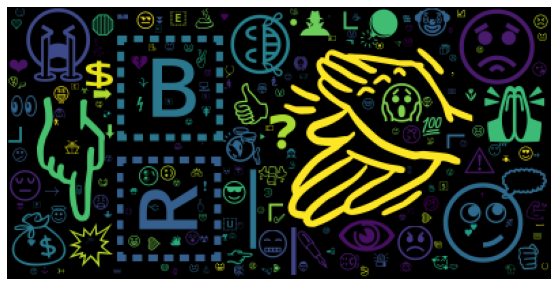

In [ ]:
# gera um dataframe onde cada linha é um emoji
emojis_df = pd.DataFrame([char for char in emojis], columns=["emojis"])

import wordcloud
import matplotlib.pyplot as plt

# Gera um Worcloud com a fonte 'Symbola.otf', que desenha emojis, usando como 
# expressão regular para a palavra qualquer UM caracter.
wc = wordcloud.WordCloud(
    font_path="files/Symbola.otf", 
    collocations=False,
    regexp = r'.').generate(emojis)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis("off")
plt.show()

Com base nesses emojis, foi gerada uma lista de unigramas com sua frequência observada no corpus e criado, manualmente, o dicionário para tradução tendo como ponto de corte os emojis com frequência acumulada superior a 85%. O método gerado será aplicado mais a frente junto com outras manipulações de string.

In [ ]:
# Agrupa por emoji e frequencia observada
emoji_grouped_df = emojis_df['emojis'].value_counts().reset_index()
# Renomeia as colunas
emoji_grouped_df.columns = ['emoji', 'counts']
# Acrescente o código unicode, para depois gerar o dicionário
emoji_grouped_df["emoji_utf"] = emoji_grouped_df["emoji"].str.encode("unicode-escape")

# Gera a soma acumulada das frequências
emoji_grouped_df["freq_ratio"] = emoji_grouped_df["counts"].cumsum()/emoji_grouped_df["counts"].sum()
# Determina o ponto de corte que represente 85% das observações de emoji
emoji_grouped_df[emoji_grouped_df["freq_ratio"] < 0.85].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 52
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   emoji       53 non-null     object 
 1   counts      53 non-null     int64  
 2   emoji_utf   53 non-null     object 
 3   freq_ratio  53 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.1+ KB


In [ ]:
ponto_de_corte = len(emoji_grouped_df[emoji_grouped_df["freq_ratio"] < 0.85])
ponto_de_corte

53

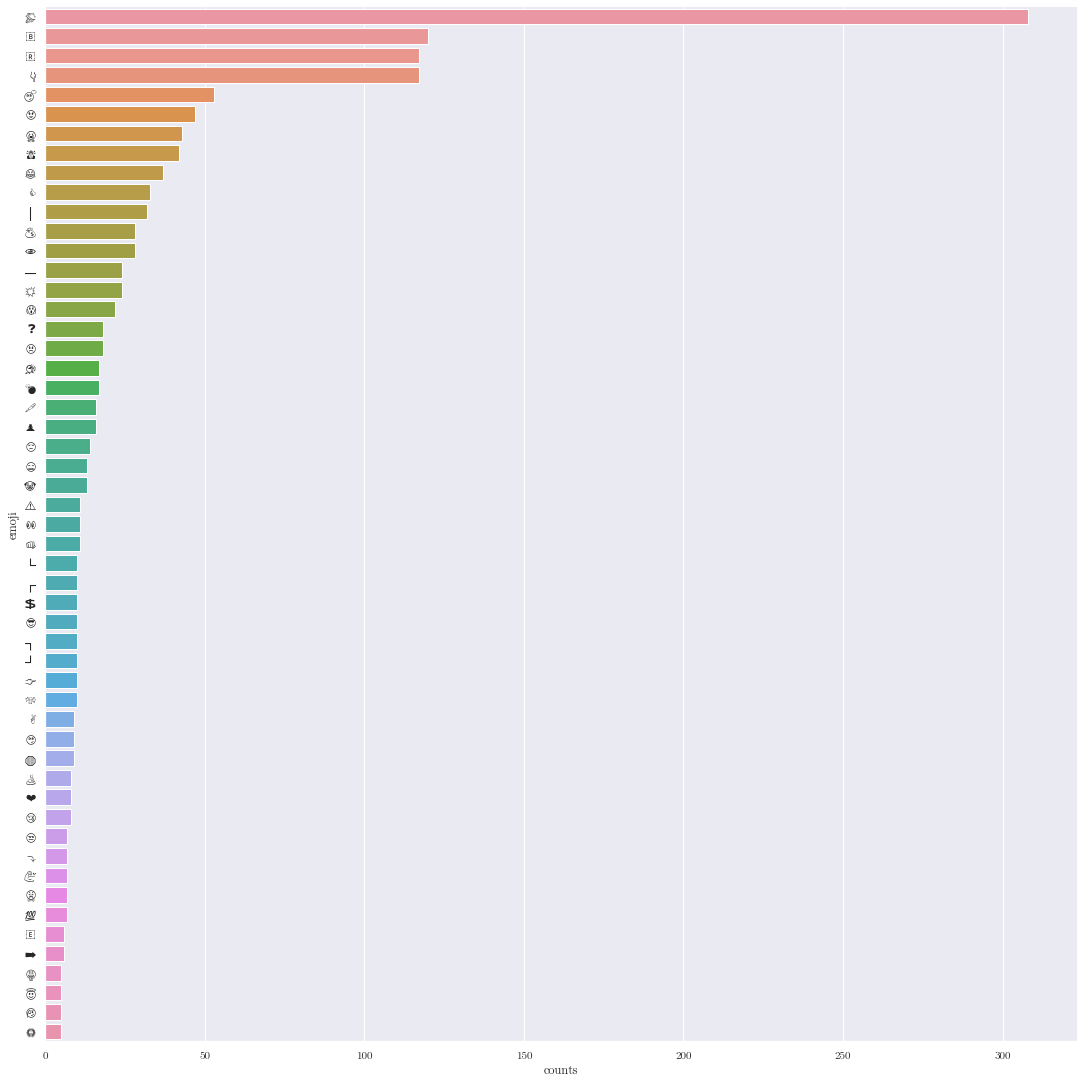

In [ ]:
from matplotlib.font_manager import fontManager, FontProperties
fontManager.addfont(path="files/Symbola.otf")
prop = FontProperties(fname="files/Symbola.otf")

plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['axes.unicode_minus']=False

import seaborn as sns
sns.set(font=prop.get_name())
sns.catplot(x="counts", y="emoji", data=emoji_grouped_df.head(ponto_de_corte), kind="bar", height=15)


Para melhor facilitar a implementação do "tradutor", mostra-se esses emojis mais usados como lista:

In [ ]:
emoji_grouped_df.head(ponto_de_corte)

,emoji,counts,emoji_utf,freq_ratio
0,👏,308,b'\\U0001f44f',0.180222
1,🇧,120,b'\\U0001f1e7',0.250439
2,🇷,117,b'\\U0001f1f7',0.318900
3,👇,117,b'\\U0001f447',0.387361
4,🤔,53,b'\\U0001f914',0.418373
5,😡,47,b'\\U0001f621',0.445875
6,😭,43,b'\\U0001f62d',0.471036
7,🙏,42,b'\\U0001f64f',0.495611
8,😂,37,b'\\U0001f602',0.517262
9,👍,33,b'\\U0001f44d',0.536571


E, então, implementa-se o método de conversão de emojis para palavras.

In [ ]:
# Percorre o dicionario, substituindo as ocorrências das chaves pelo valores ao
# longo do texto.
def convert_emoji_to_text(text):
  emoji_map = {
    '\U0001f44f': "parabéns",
    '\U0001f1e7\U0001f1f7': "Brasil",
    '\U0001f447': "olhem isso",
    '\U0001f4a5': "explosão",
    '\U0001f914': "pensativo",
    '\U0001f4a3': "bomba",
    '\U0001f621': "que raiva",
    '\U0001f64f': "graças a Deus",
    '\U0001f602': "risos",
    '\U0001f44d': "legal",
    '\U0001f62d': "muito triste",
    '\U0001f4b0': "dinheiro",
    '\U0001f441': "olhem isso",
    '\U0001f4b2': "dinheiro",
    '\U0001f631': "espantoso",
    '\u2753': "? ",
    '\U0001f620': "que raiva",
    '\U0001f923': "muitos risos",
    '\U0001f58b': "canetada",
    '\U0001f575': "fiscalização",
    '\U0001f614': "triste",
    '\U0001f62c': "ops",
    '\U0001f921': "palhaçada",
    '\U0001f44a': "porrada",
    '\U0001f623': "que porcaria",
    '\U0001f449': "olhem isso",
    '\U0001f440': "olhem isso",
    '\U0001f60e': "feliz",
    '\U0001f4b8': "dinheiro voando",
    '\u270c': "paz",
    '\U0001f644': "que chato",
    '\U0001f6d1': "pare",
    '\U0001f622': "triste",
    '\U0001f4a9': "que merda",
    '\U0001f624': "que raiva",
    '\u2764': "amor",
    '\U0001f4af': "cem porcento",
    '\u2935': "olhem isso",
    '\U00011f615': "chateado",
    r' :\'?-?\( ': "triste",
    r' :-?\) ': "feliz",
    r' :-?D ': "feliz"
  }

  for key in emoji_map:
    text = re.sub(key, ". " + emoji_map[key] + "! ", text)
  
  return text


## 4.2. Análise e processamento geral do texto

Com o intuito de limpar um pouco o corpus onde necessário e agregar mais informação onde pode ser útil, decidiu-se fazer alguns tratamentos no texto:
-	remoção de menções (nomes próprios das contas de Twitter iniciadas com arroba), pois geralmente são neutras e não agregariam ao modelo;
-	remoção de links, pois não dão indicações claras se são negativos ou positivos (muitos links direcionam para imagens, que podem ter cunho negativo ou positivo, fugindo do escopo desse trabalho que é a análise de sentimentos textual);
-	transformação de "#hashtags", pois são formadas pela junção de palavras, assim, se tentará separar as palavras sempre que utilizar formatos "snake_case" ou "camelCase";
-	padronização de risadas do tipo "kkkk...", transformando para "kkk", sendo assim consideradas um único tipo de palavra;
-	retirada de excessos de espaços e quebras de linha;
-	remoção dos caracteres restantes que não sejam pontuação, letras e números.


In [ ]:
import re

# Remove menções no texto do tipo "@nomedaconta"
def remove_mentions(text):
  text = re.sub('@[\w_-]+ ', " ", text)
  return text

# Converte hashtags para palavras. E.g.: #praFrenteBrasil => pra frente brasil
def convert_hashtag_to_words(text):

  # Procura o texto que começe com # seguido de letras, números, "_" ou "-"
  for m in re.finditer('#([\w_-]+)', text):
    hashtag = m.group(1);

    # Procura uma letra maiúscula seguida de minúscula e acrescenta-se um espaço
    # imediatamente antes
    hashtag = re.sub('(.)([A-Z][a-z]+)', r'\1 \2', hashtag)
    # Procura uma letra minúscula ou número seguida de maiúscula e acrescenta-se
    # um espaço imediatamente entre eles
    hashtag = re.sub('([a-z0-9])([A-Z])', r'\1 \2', hashtag)
    # Substitui "_" ou "-" por espaço
    hashtag = re.sub('[_-]', " ", hashtag)
    
    text = re.sub(m.group(0), ". Assunto: " + hashtag + "! ", text)
  
  return text

# Remove URLs 
def remove_urls(text):
  return re.sub(r'https?:\/\/[^\s]+', " ", text)

# Remove escesso de espaços
def remove_spaces(text):
  text = re.sub("[\r\n]", " ", text)
  return re.sub('\s+', " ", text)

# Reduz risadas com 'kkkk...' a 'kkk'
def normalize_laughs(text):
  return re.sub(r'k{4,}', "kkk", text, flags=re.IGNORECASE)

# Remove pontuações duplicadas
def remove_punctuation_duplicates(text):
  return re.sub(r'([\,\;\.\-\_\!\?]) [\,\;\.\-\_\!\?]', r'\1 ', text)

# Remove o que não for letra, número, ".", ",", ";", "!", "?"
def remove_others(text):
  return re.sub('[^\w\.,;\!\?]', " ", text)

def clean_text(text):
  text = convert_hashtag_to_words(text)
  text = remove_mentions(text)
  text = remove_urls(text)
  text = convert_emoji_to_text(text)
  text = normalize_laughs(text)
  text = remove_punctuation_duplicates(text)
  text = remove_others(text)
  text = remove_spaces(text)
  return(text)


In [ ]:
balanced_df["clean_text"] = balanced_df["text"].apply(clean_text)

## 4.3. Palavras com baixa relevância e sufixos

Como será visto mais a frente, para se trabalhar com alguns modelos de aprendizado de máquina, o texto é transformado em matrizes esparsas. Assim, é útil aplicar algumas técnicas de processamento de linguagem natural que ajudem a reduzir a dimensionalidade dessas matrizes. Uma das técnicas é a remoção de palavras muito comuns, chamadas "stop words", pois, geralmente, tem pouco impacto nos modelos. Nesse trabalho foi utilizada a lista da biblioteca spacy, no entanto, foram mantidas algumas palavras que podem inverter o sentido de um sentimento - por exemplo: “não”, “nem”, “nunca”, “nenhuma”, “nenhum”.

Existem ainda outras duas técnicas que podem ser utilizadas:
-	remoção de sufixos (Stemmer): remove sufixos das palavras. Exemplo: “obrigado” e “obrigada” se transformam em “obrig”.
-	lematização: transforma as palavras para seu lema, levando em consideração o contexto em que a palavra se encontra no texto. Exemplo: “meninas”, “menina”, “menino” e “meninos” viram “menino”.

Pela segunda técnica demandar maior tempo computacional, será utilizada a remoção de sufixos, com o algoritmo RSLP (remoção de sufixos da língua portuguesa) da biblioteca nltk. Mas a título de conhecimento, o código para lematização usando a biblioteca spacy também é apresentado no notebook gerado.


In [ ]:
import spacy
import nltk
spacy.require_gpu()
spacy.cli.download("pt_core_news_lg")
nlp = spacy.load('pt_core_news_lg')

nltk.download('punkt')
nltk.download('rslp')

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS - set(["não", "nem", "nunca", "nenhuma", "nenhum"])

stemmer = nltk.stem.RSLPStemmer()

# Remove stopwords e aplica o stemmer RSLP ao texto
def keep_important_words(text):
  text = re.sub(r'[^\w-]', ' ', text).lower()
  text = re.sub(r'\b[\w-]{,2}\b', ' ', text)
  filtered_words = [
      stemmer.stem(word) for word in text.split() if word not in stop_words.union(set(["assunto"]))
  ]
  return " ".join(filtered_words)

# Transforma todas as palavras para seu lemma, utilizando 
# o modelo pré-treinado "pt_core_news_lg"
def lemmatize(text):
  lemma = ""
  for token in nlp(text.lower()):
    if(token in stop_words):
      continue
    lemma += token.lemma_ + " "
  return lemma

Esse tratamento é aplicado à coluna “cleaned_text” e guardado na coluna “important_words”. Feitos esses diversos tratamentos no texto, o dataset foi salvo para se treinar modelos na próxima seção.

In [ ]:
balanced_df["important_words"] = balanced_df["clean_text"].apply(
    keep_important_words
)

In [ ]:
balanced_df = balanced_df.reset_index(drop=True)

In [ ]:
balanced_df.to_json(path_or_buf="datasets/balanced_df.json")

In [ ]:
balanced_df.drop("sentiment", axis=1).head()

,created_at,text,origin,sentiment_binary,clean_text,important_words
0,2018-08-22 02:21:49,AI QUE LINDO :((( TINHA Q TER SIDO ESCOLHIDO,tweets_pt,0,AI QUE LINDO TINHA Q TER SIDO ESCOLHIDO,lind tinh sid escolh
1,2018-09-27 16:20:19,fds prolongado :D,tweets_pt,1,fds prolongado D,fd prolong
2,2018-09-27 14:51:43,@CoraBarbiery Arranque miija!!! :) :) :) :),tweets_pt,1,Arranque miija!!!. feliz! . feliz!,arranqu miij feliz feliz
3,2018-08-17 00:55:44,parei exatamente agora de mexer com material d...,tweets_pt,1,parei exatamente agora de mexer com material d...,par exat mex mater campanh simples 11h manhã niss
4,2018-08-20 00:59:20,A votar por Marcela Navarro!! :) #L4FGranFinal...,tweets_pt,1,A votar por Marcela Navarro!!. feliz! Assunto ...,vot marcel navarr feliz gran lo cuatr final


## 4.4. N-gramas por sentimento

Antes de partir para o treinamento de modelos, é interessante tentar fazer mais algumas análises sobre o dataset. Por isso, foram analisadas quais as palavras da coluna “important_words” mais aparecem para cada categorização de sentimento.


In [ ]:
import collections
import nltk
from nltk.util import ngrams

# Mostra uma lista de tamanho "size" separa por categoria de sentimento
# para cada tipo de n-grama solicitado (por padrão, unigrama e bigrama) 
def show_ngrams_by_sentiment(df, ngram_types=[1,2], size=10):
  
  # Para cada ngram solicitado
  for ngram in ngram_types:
    print("\n\n{}-gram:".format(ngram))

    # Para as 2 categorias de sentimentos
    for sentiment in [0, 1]:
      print("\n\nSentiment: {}".format(sentiment))
      same_category_text = " ".join(
          df[df["sentiment_binary"] == sentiment]["important_words"]
      )
      
      # Separa em n-gramas
      list_ngrams = ngrams(re.sub(r'[^\w-]', ' ', same_category_text).split(), ngram)

      # Conta as ocorrências de n-gramas
      ngrams_count = collections.Counter(list_ngrams)

      ngram_df = pd.DataFrame.from_dict(ngrams_count, orient='index').reset_index()
      ngram_df = ngram_df.rename(columns={'index':'ngram', 0:'count'})

      display(ngram_df.sort_values("count", ascending=False).head(size))

print("Para o conjunto de datasets:")
show_ngrams_by_sentiment(balanced_df)

Para o conjunto de datasets:


1-gram:


Sentiment: 0


,ngram,count
15,"(não,)",111865
44,"(trist,)",102533
10,"(film,)",55835
169,"(pra,)",30595
298,"(quer,)",28769
50,"(fic,)",19805
105,"(ach,)",16205
113,"(vou,)",15820
288,"(nem,)",14220
12,"(real,)",13608




Sentiment: 1


,ngram,count
66,"(não,)",121274
141,"(film,)",92528
4,"(feliz,)",89923
32,"(pra,)",30014
381,"(dia,)",22161
69,"(melhor,)",22145
284,"(real,)",21199
83,"(gost,)",20732
57,"(ach,)",20054
354,"(pesso,)",19251




2-gram:


Sentiment: 0


,ngram,count
1331,"(trist, trist)",5293
187,"(trist, não)",5274
41,"(film, não)",3362
1421,"(trist, quer)",3304
375,"(pra, mim)",2989
3123,"(não, trist)",2873
1416,"(não, vou)",2463
416,"(não, consig)",2426
473,"(fic, trist)",2038
1274,"(assist, film)",2029




Sentiment: 1


,ngram,count
613,"(film, não)",4215
2032,"(feliz, não)",3618
5121,"(assist, film)",2649
6412,"(val, pen)",2631
1565,"(não, gost)",2458
4,"(feliz, feliz)",2290
723,"(melhor, film)",2130
1049,"(gost, film)",1872
1816,"(não, não)",1826
307,"(não, vou)",1797


Na análise dos unigramas (palavras) por sentimento observa-se algumas coisas:
-	a palavra "não" é a que mais aparece nas 2 categorias, o que já era esperado, por ser um tipo de "stop word";
-	a palavra "film" (filme) aparece bastante nas 2 categorias, o que pode ser explicado pelo uso de um dataset temático de classificação de filmes;
-	a palavra "trist" (triste, tristeza) tem destaque na categoria 0 (sentimento negativo), enquanto a palavra "feliz" tem destaque na categoria 1 (sentimento positivo);

Já a análise de bigramas com ordem (duplas de palavras em sequência) não forneceu nenhum insight relevante.


Agora, será feita a mesma a análise apenas para os textos direcionados à RFB.

In [ ]:
show_ngrams_by_sentiment(balanced_df[balanced_df["origin"] == "tweets_rfb"])



1-gram:


Sentiment: 0


,ngram,count
57,"(não,)",198
125,"(brasil,)",79
97,"(receit,)",68
142,"(pra,)",62
156,"(dia,)",61
16,"(impost,)",59
215,"(pag,)",55
17,"(ps5,)",51
47,"(sit,)",49
34,"(pens,)",46




Sentiment: 1


,ngram,count
0,"(parabém,)",325
11,"(brasil,)",111
100,"(olh,)",69
116,"(receit,)",41
136,"(não,)",32
87,"(dia,)",30
8,"(impost,)",29
86,"(trabalh,)",26
150,"(feder,)",24
3,"(pra,)",23




2-gram:


Sentiment: 0


,ngram,count
54,"(ps5, xbox)",43
55,"(xbox, barat)",42
325,"(receit, feder)",33
1461,"(raiv, raiv)",17
1014,"(stf, vergonh)",14
1785,"(vergonh, nacion)",13
1786,"(nacion, stf)",12
1835,"(pens, pens)",12
4216,"(palhaç, palhaç)",11
155,"(abaix, impost)",10




Sentiment: 1


,ngram,count
269,"(parabém, parabém)",201
337,"(olh, olh)",42
11,"(brasil, brasil)",35
178,"(receit, feder)",20
180,"(ps5, xbox)",14
309,"(graç, deu)",14
270,"(parabém, brasil)",14
181,"(xbox, barat)",13
116,"(impost, rend)",11
247,"(parabém, receit)",11


Nessa outra análise, o uso de bigramas trouxe mais contexto e permitiu uma melhor separação entre categorias:
-	(ps5, xbox) aparece muito mais como sentimento negativo, o que se explica por uma campanha da população nas redes sociais para redução de impostos nos videogames
-	(parabém, parabém), (olho, olho), (brasil, brasil) para sentimentos positivos e (raiv, raiv), (palhaç, palhaç) para sentimentos negativos, mostram uma boa dicotomia de sentimentos e a repetição dessas palavras se explica por serem emojis no texto original. Isso pode ser um indicativo de que emojis serem importantes para definição dos sentimentos em redes sociais.


## 4.5. Insights de sentimentos com relação a períodos de tempo

Em seguida, vamos analisar como é a distribuição dos dados no tempo e se seria possível estabelecer alguma relação entre os sentimentos no tempo.

Para manipular melhor as datas, foram criadas as seguintes colunas auxiliares: ano ("year"), mês ("month"), dia ("day"), dia da semana ("week_day").

In [ ]:
# separa a data por campos de interesse para futuro agrupamento
balanced_df["year"] = balanced_df["created_at"].dt.year
balanced_df["month"] = balanced_df["created_at"].dt.month
balanced_df["day"] = balanced_df["created_at"].dt.date
balanced_df["week_day"] = balanced_df["created_at"].dt.strftime('%a')

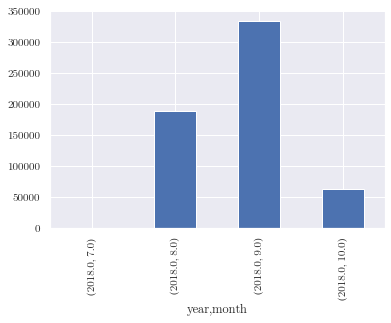

In [ ]:
# gera gráfico agrupado por mês/ano para o dataset
# Tweets em português
balanced_df[balanced_df["origin"] == "tweets_pt"].groupby(
    ['year', 'month']
).size().plot(kind = 'bar')

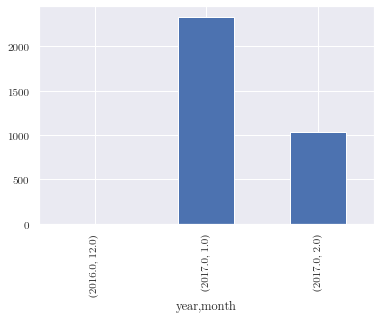

In [ ]:
# gera gráfico agrupado por mês/ano para o dataset
# Tweets MG/BR
balanced_df[balanced_df["origin"] == "tweets_mg"].groupby(
    ['year', 'month']
).size().plot(kind = 'bar')

Ao se buscar insights entre as colunas “sentiment_binary” e “created_at”, verificou-se que os dados dos dataset “Tweets em português para análise de sentimentos” e “Tweets MG/BR” são concentrados em poucos meses, conforme figuras acima. 

Dessa forma, limitou-se a análise apenas aos “Tweets classificados RFB”, visto que esses dados são mais bem distribuídos ao longo do tempo, além de serem os dados de interesse no problema em questão. Pela figura a seguir verifica-se que esse dataset possui dados desde 2009 (ano de criação da conta RFB no Twitter) até o início de 2021 (quando foi feita a extração pela API).

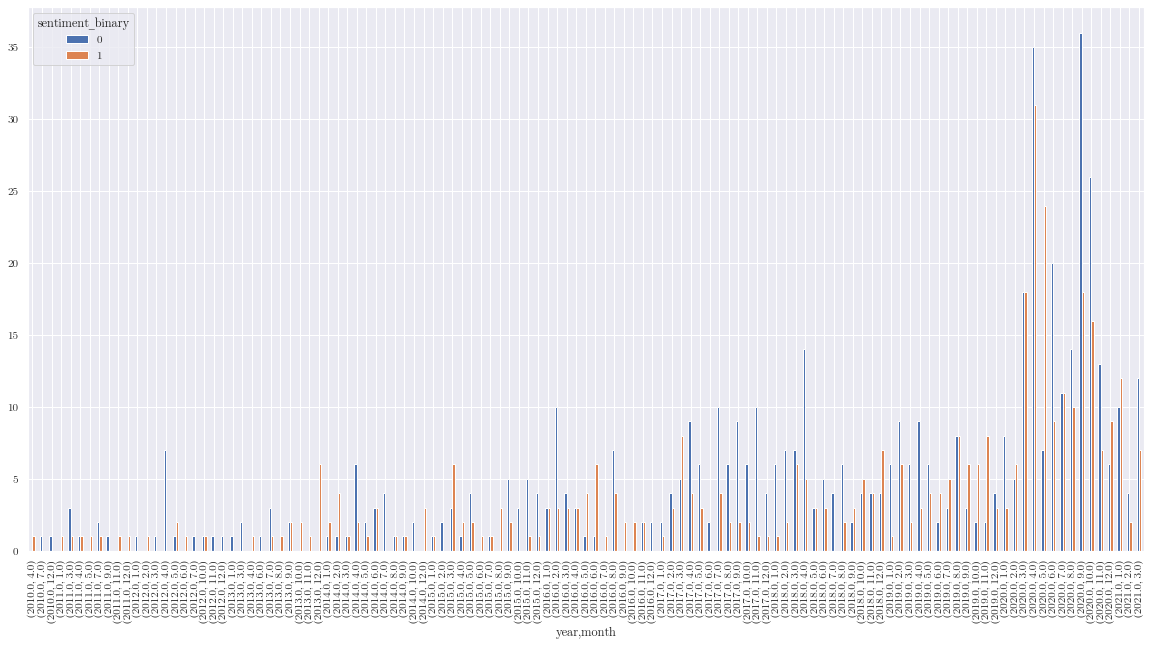

In [ ]:
# gera gráfico agrupado por mês/ano para o dataset
# Tweets classificados RFB
balanced_df[
  balanced_df["origin"] == "tweets_rfb"
].groupby(
  ['year', 'month', 'sentiment_binary']
).size().unstack(level=2).plot(kind = 'bar', figsize=(20,10))

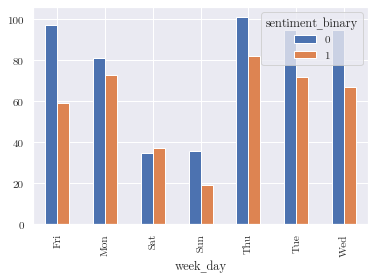

In [ ]:
# gera gráfico agrupado por dia da semana para o dataset
# Tweets classificados RFB
balanced_df[
  balanced_df["origin"] == "tweets_rfb"
].groupby(
    ['week_day', 'sentiment_binary']
).size().unstack(level=1).plot(kind = 'bar')

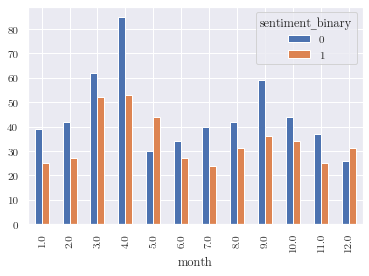

In [ ]:
# gera gráfico agrupado por mês para o dataset
# Tweets classificados RFB
balanced_df[
  balanced_df["origin"] == "tweets_rfb"
].groupby(['month', 'sentiment_binary']).size().unstack(level=1).plot(kind = 'bar')

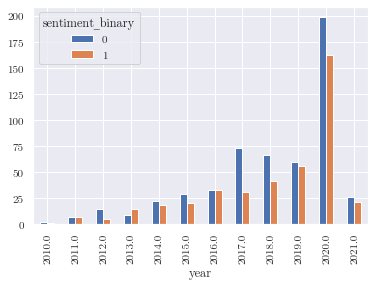

In [ ]:
# gera gráfico agrupado por ano para o dataset
# Tweets classificados RFB
balanced_df[
  balanced_df["origin"] == "tweets_rfb"
].groupby(['year', 'sentiment_binary']).size().unstack(level=1).plot(kind = 'bar')

Os gráficos anteriores permitem fazer algumas inferências sobre o dataset “Tweets classificados RFB”. Deve-se lembrar que a escolha dos tweets para classificação foi aleatória e correspondente a cerca de 8,18% do dataset “Tweets RFB”. As principais observações foram as seguintes:
-	há uma tendência de alta geral nos tweets, o que mostra maior engajamento do público com a conta ao longo do tempo;
-	para o ano de 2021, há uma prevalência de tweets positivos;
-	os sentimentos negativos geralmente superam os sentimentos positivos, sendo a maior diferença observada às sextas-feiras, já nos sábados os sentimentos positivos são superiores;
-	o mês com maior pico de mensagens e, também, de sentimentos negativos é o mês de abril, justamente o mês limite para entrega da declaração do imposto de renda pessoa física (IRPF).

Pela pequena distribuição dos demais datasets no tempo, o uso do tempo como entrada para os modelos será descartado no presente trabalho. Deixaremos a análise desta variável para trabalhos futuros.



# 5. Criação de Modelos de Machine Learning





## 5.1. Definição das features

Nesse trabalho adotamos abordagem tradicional de transformar atributos textuais em vetores. Cada tweet é transformado em um vetor onde cada posição do vetor corresponde a uma palavra no vocabulário completo (corpus do dataset). Testamos duas opções para o conteúdo armazenado em cada posição:
-	Contagem de palavras: conta as ocorrências de cada palavra no texto;
-	TF-IDF: do inglês “term frequency–inverse document frequency”, é uma medida estatística para indicar a importância de palavra em um documento, levando em consideração a frequência dessa palavra em um conjunto de documentos.

As implementações da biblioteca sklearn que correspondem a essas duas opções são CountVectorizer e TfidfVectorizer, sendo que ambas separam o texto em palavras, fazendo cada palavra do corpus passa a corresponder a uma posição no vetor, diferenciando apenas pela forma como cada posição do vetor que corresponde a uma palavra é calculada.

Já para os modelos de aprendizado profundo utilizados nesse trabalho, a transformação para vetor não ocorre dessa forma. Eles possuem tokenizadores próprios para os seus processamentos, não utilizando as duas opções anteriores. Nesses casos, será comparada a acurácia de se treinar o modelo tendo como entrada o texto original (coluna “text”), texto tratado (coluna “clean_text”) ou o texto com dimensionalidade reduzida (coluna “important_words”).

Para avaliação de todos os modelos, será utilizado o Índice de Jaccard, que para o caso de classificação binária pode ser simplificado como a razão entre os itens corretamente classificados e a totalidade desses itens. Como o dataset está balanceado, qualquer valor acima de 50% indica uma melhora do modelo em relação a uma escolha aleatória.


In [ ]:
# Carrega o dataset pronto se o notebook não for executado desde o início
if ("balanced_df" not in vars()):
  import pandas as pd
  random_state = 0
  balanced_df = pd.read_json("datasets/balanced_df.json").astype(
      {"created_at": "datetime64"}
  )

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, confusion_matrix

Logo ao tentar executar o primeiro modelo, ocorreu um erro de falta de memória, devido a quantidade de itens no dataset. Então, reduziu-se o dataset de forma aleatória, novamente mantendo todos os itens originários do dataset “Tweets classificados RFB”, para que não se perdesse essa informação.

In [ ]:
# seleciona aleatoriamente 30.000 linhas que não sejam do 
# dataset "Tweets classificados RFB"
used_df = balanced_df[balanced_df["origin"] != "tweets_rfb"].sample(
    30000,
    random_state=random_state
)
# Reacrescenta as linhas do dataset "Tweets classificados RFB"
used_df = used_df.append(balanced_df[balanced_df["origin"] == "tweets_rfb"])
used_df = used_df.sample(frac=1, random_state=random_state)

display(used_df["origin"].value_counts())

tweets_pt     27921
imdb_pt        1906
tweets_rfb      949
tweets_mg       173
Name: origin, dtype: int64

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# cria os vetores com no máximo 2500 palavras, sendo que são palavras que 
# aparecem no mínimo 7 vezes e no máximo em 90% das linhas
tfidf_vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.9)
count_vectorizer = CountVectorizer(max_features=2500, min_df=7, max_df=0.9)

# gera as novas features utilizando vetorização
text_tfidfv = tfidf_vectorizer.fit_transform(used_df["important_words"])
text_countv = count_vectorizer.fit_transform(used_df["important_words"])


Feito isso, realizou-se a divisão do dataset em dataset de treinamento e dataset de teste na proporção de 80% e 20%, utilizando-se sempre esses dois conjuntos para se treinar e testar os modelos.  Foi utilizado um seed (“random_state”), para que os resultados pudessem ser replicados.

Para se facilitar a execução de células individualmente, a divisão em treinamento e teste é replicada em algumas células, usando sempre o mesmo seed.

In [ ]:
# Divide o dataset em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    text_tfidfv,
    used_df["sentiment_binary"],
    test_size=0.2,
    random_state=random_state)

## 5.2. Naive Bayes

O primeiro modelo testado foi o MultinomialNaiveBayes, que é um modelo baseado no Teorema de Probabilidade de Bayes, considerando, de forma “ingênua”, que não há correlação entre as variáveis envolvidas, ou seja, que não há correlação entre as diversas palavras do texto no caso desse trabalho.

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      3074
           1       0.77      0.73      0.75      3116

    accuracy                           0.75      6190
   macro avg       0.75      0.75      0.75      6190
weighted avg       0.75      0.75      0.75      6190

0.7529886914378029


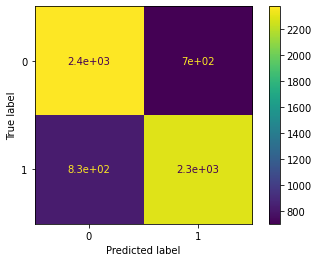

In [ ]:
from sklearn.naive_bayes import MultinomialNB
# Executa o modelo MultinomialNB com a feature TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(
    text_tfidfv,
    used_df["sentiment_binary"],
    test_size=0.2,
    random_state=random_state)
nb_model = MultinomialNB().fit(X_train.toarray(), y_train)
predictions = nb_model.predict(X_test.toarray())

print(plot_confusion_matrix(nb_model, X_test.toarray(), y_test))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      3074
           1       0.80      0.66      0.73      3116

    accuracy                           0.75      6190
   macro avg       0.76      0.75      0.75      6190
weighted avg       0.76      0.75      0.75      6190

0.7479806138933764


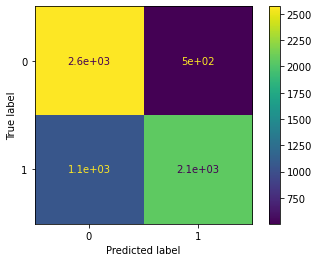

In [ ]:
# Executa o modelo MultinomialNB com a feature CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(
    text_countv, 
    used_df["sentiment_binary"], 
    test_size=0.2, 
    random_state=random_state
)
nb_model = MultinomialNB().fit(X_train.toarray(), y_train)
predictions = nb_model.predict(X_test.toarray())

print(plot_confusion_matrix(nb_model, X_test.toarray(), y_test))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

Para esse modelo, o vetor TFIDF apresentou melhores resultados (75,30% de acurácia) que o vetor de contagem de palavras (74,80% de acurácia) para o conjunto de treinamento, o que está dentro do esperado, já que o TFIDF pontua melhor palavras mais relevantes.

## 5.3. Regressão Logística

Testou-se, também, o modelo de regressão logística, um modelo estatístico que utiliza uma função logística (uma curva do tipo sigmóide) para modelar uma variável binária dependente (no caso, sentimento “0” ou  “1”). 

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      3074
           1       0.76      0.83      0.79      3116

    accuracy                           0.78      6190
   macro avg       0.78      0.78      0.78      6190
weighted avg       0.78      0.78      0.78      6190

0.7796445880452343


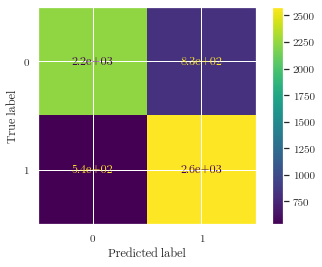

In [ ]:
# Executa o modelo LogisticRegression com a feature TfidfVectorizer
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
  text_tfidfv, 
  used_df["sentiment_binary"], 
  test_size=0.2, 
  random_state=random_state
)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Executa as previsões
predictions = lr_model.predict(X_test)
plot_confusion_matrix(lr_model, X_test, y_test)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      3074
           1       0.75      0.79      0.77      3116

    accuracy                           0.77      6190
   macro avg       0.77      0.77      0.77      6190
weighted avg       0.77      0.77      0.77      6190

0.7657512116316639


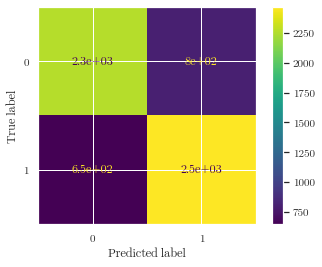

In [ ]:
# Executa o modelo LogisticRegression com a feature CountVectorizer
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    text_countv, used_df["sentiment_binary"],
    test_size=0.2,
    random_state=random_state
)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Executa as previsões
predictions = lr_model.predict(X_test)
plot_confusion_matrix(lr_model, X_test, y_test)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

Novamente nessa situação, o vetor TFIDF apresentou melhores resultados (77,96% de acurácia) que o vetor de contagem de palavras (76,58% de acurácia) para o conjunto de treino, obtendo um resultado ligeiramente melhor que o Naive Bayes.

## 5.4. Random Forest

Foi testado também o modelo de classificador Random Forest, um modelo de aprendizado conjunto que constrói diversas árvores de decisão para cada subconjunto do dataset e utiliza a média dessas ávores para reduzir overfitting e melhorar a acurácia. Definiu-se o número de árvores de decisão (*n_estimators*) como 100, padrão atual da bilioteca.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Executa o modelo RandomForestClassifier com a feature TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(
  text_tfidfv, 
  used_df["sentiment_binary"], 
  test_size=0.2, 
  random_state=random_state
)


rf_model = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, 'models/random_forest_tfidf.joblib')


              precision    recall  f1-score   support

           0       0.79      0.73      0.76      3074
           1       0.75      0.81      0.78      3116

    accuracy                           0.77      6190
   macro avg       0.77      0.77      0.77      6190
weighted avg       0.77      0.77      0.77      6190

0.7678513731825525


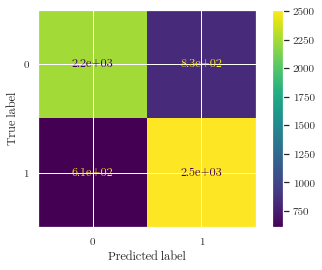

In [ ]:
# Verifica as métricas do modelo RandomForestClassifier
# com a feature TfidfVectorizer

rf_model = joblib.load('models/random_forest_tfidf.joblib')
X_train, X_test, y_train, y_test = train_test_split(
    text_tfidfv, 
    used_df["sentiment_binary"], 
    test_size=0.2, 
    random_state=random_state
)

# Executa as previsões
predictions = rf_model.predict(X_test)

print(plot_confusion_matrix(rf_model, X_test, y_test))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
# Executa o modelo RandomForestClassifier com a feature CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(text_countv, used_df["sentiment_binary"], test_size=0.2, random_state=random_state)

rf_model = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, 'models/random_forest_count.joblib')

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      3074
           1       0.75      0.77      0.76      3116

    accuracy                           0.76      6190
   macro avg       0.76      0.76      0.76      6190
weighted avg       0.76      0.76      0.76      6190

0.7594507269789984


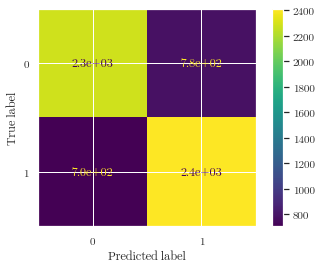

In [ ]:
# Verifica as métricas do modelo RandomForestClassifier
# com a feature CountVectorizer

rf_model = joblib.load('models/random_forest_count.joblib')

X_train, X_test, y_train, y_test = train_test_split(text_countv, used_df["sentiment_binary"], test_size=0.2, random_state=random_state)

# Executa as previsões
predictions = rf_model.predict(X_test)

print(plot_confusion_matrix(rf_model, X_test, y_test))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

O melhor caso para esse modelo foi inferior ao TFIDF com regressão logística, obtendo 76,79% de acurácia para o vetor TFIDF e 75,94% para o vetor de contagem de palavras.

## 5.5. XGBoost

Para o uso modelo XGBoost, desabilitou-se o uso da GPU para treinamento, por apresentar resultados muito inferiores ao processamento por CPU.
O XGBoost é um modelo de Gradiente Boost, ou seja, ele possui um conjunto de modelos diversos que aprendem apenas uma parcela das features e utiliza o resultado desses modelos fracos para gerar um modelo forte, com maior acurácia.

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# Executa o modelo XGBClassifier com a feature TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(
  text_tfidfv, 
  used_df["sentiment_binary"], 
  test_size=0.2, 
  random_state=random_state
)


xgb_model = XGBClassifier(
  max_depth=6, 
  n_estimators=1000, 
  max_bin=16, 
  nthread=8
).fit(X_train, y_train)
pickle.dump(xgb_model, open('models/xgb_tfidf.model', "wb"))

              precision    recall  f1-score   support

           0       0.81      0.71      0.75      3074
           1       0.74      0.83      0.79      3116

    accuracy                           0.77      6190
   macro avg       0.77      0.77      0.77      6190
weighted avg       0.77      0.77      0.77      6190

0.7704361873990307


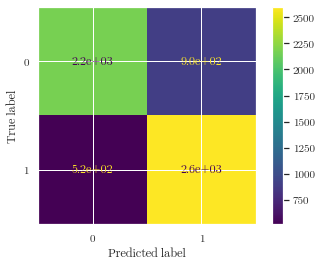

In [ ]:
# Verifica as métricas do modelo XGBClassifier
# com a feature TfidfVectorizer

xgb_model = pickle.load(open("models/xgb_tfidf.model", "rb"))
X_train, X_test, y_train, y_test = train_test_split(
    text_tfidfv, 
    used_df["sentiment_binary"], 
    test_size=0.2, 
    random_state=random_state
)

# Executa as previsões
predictions = xgb_model.predict(X_test)

plot_confusion_matrix(xgb_model, X_test, y_test)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
# Executa o modelo XGBClassifier com a feature CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(
  text_countv, 
  used_df["sentiment_binary"], 
  test_size=0.2, 
  random_state=random_state
)


xgb_model = XGBClassifier(
  max_depth=6, 
  n_estimators=1000, 
  max_bin=16, 
  nthread=8
).fit(X_train, y_train)
pickle.dump(xgb_model, open('models/xgb_count.model', "wb"))

              precision    recall  f1-score   support

           0       0.81      0.71      0.75      3074
           1       0.74      0.83      0.79      3116

    accuracy                           0.77      6190
   macro avg       0.78      0.77      0.77      6190
weighted avg       0.77      0.77      0.77      6190

0.7709208400646204


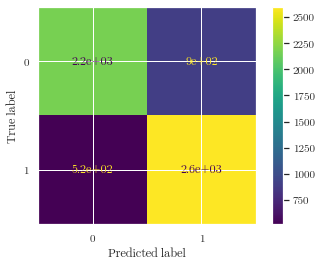

In [ ]:
# Verifica as métricas do modelo XGBClassifier
# com a feature CountVectorizer

xgb_model = pickle.load(open("models/xgb_count.model", "rb"))
X_train, X_test, y_train, y_test = train_test_split(
    text_countv, 
    used_df["sentiment_binary"], 
    test_size=0.2, 
    random_state=random_state
)

# Executa as previsões
predictions = xgb_model.predict(X_test)

plot_confusion_matrix(xgb_model, X_test, y_test)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

Nesse modelo, contrariando o esperado após a observação de outros modelos, o vetor TFIDF forneceu menor acurácia (77,04%) que o vetor de contagem de palavras (77,09%).

## 5.6. Spacy CNN

Testados alguns modelos tradicionais de aprendizado de máquina, passou-se para a comparação com modelos recentes, que utilizam técnicas de aprendizado profundo e são mais adequados ao processamento de linguagem natural. Para redução do tempo de treinamento, o dataset foi reduzido para 10.000 linhas, e, novamente, incluídas as linhas referente ao dataset “Tweets classificados RFB”.

Para esses modelos, se comparou o uso de texto original (coluna “text”), texto processado (coluna “clean_text”) e palavras reduzidas - excluindo stop words que não invertem o sentimento e com sufixo retirado - (coluna “important_words”).

O primeiro desses modelos específicos utilizado foi o spacy, na versão 3, uma biblioteca de processamento de linguagem natural que geralmente apresentas bons resultados com seu modelo de redes neurais convolucionais (CNN). CNNs são um tipo específico de redes neurais artificais que apresentam camadas convolucionais, cuja característica é limitação da conexões de um neurônio a uma área contígua da camada anterior ou dos dados de entrada. Dessa forma, pode-se dizer que, para NLP, o uso de CNNs permite incluir contexto no processo de aprendizado de máquina, com abstrações relativas à sequência de palavras, ao invés de analisar palavras de forma independente.


In [ ]:
# Reduz o tamanho do dataset para 10.000 linhas
used_df = balanced_df[balanced_df["origin"] != "tweets_rfb"].sample(
    10000, random_state=random_state
)
used_df = used_df.append(balanced_df[balanced_df["origin"] == "tweets_rfb"])
used_df = used_df.sample(frac=1, random_state=random_state)

Para se trabalhar com o spacy da mesma forma como é feito o treinamento e teste na biblioteca sklearn, foi criada uma classe que implemente um método “fit” e um método “predict”).

In [ ]:
import spacy
from sklearn.utils import shuffle
from spacy.util import minibatch, compounding
from spacy.training import Example

# Classe para implementar métodos parecidos com do sklearn
class SpacyModel:
  def __init__(self, nlp, epochs=5, use_gpu=False):
      self.nlp = nlp
      self.epochs = epochs

      if use_gpu:
        spacy.require_gpu()

      if 'textcat' not in nlp.pipe_names:
        textcat = nlp.add_pipe("textcat", last=True)
        textcat.add_label("POSITIVE")
        textcat.add_label("NEGATIVE")
    
  def fit(self, X, y):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    examples = []
    # Cria a lista de exemplo, que são usado para treinar o spacy
    for index, row in X.iteritems():
      doc = self.nlp.make_doc(row)
      # A categorização no spacy é feita com rótulos que possuem um booleano
      # indicando se o rótulo foi aplicado naquela categorização
      cats = {'POSITIVE': (y.iloc[index] > 0), 'NEGATIVE': (y.iloc[index] <= 0)}
      example = Example.from_dict(doc, {"cats": cats})
      examples.append(example)

    losses = {}
    # Habilita-se apenas a parte de categorização de texto "textcat"
    # para realizar o treinamento.
    with self.nlp.select_pipes(enable="textcat"):
        optimizer = self.nlp.initialize(lambda: examples)
        # Para cada época
        for itn in range(self.epochs):
          # embaralha os exemplos antes de criar os conjuntos de treinamento
          shuffle(examples, random_state=random_state)
          # Cria pequenos conjuntos de exemplos
          batches = minibatch(examples, size=compounding(4., 32., 1.001))
          for batch in batches:
            # Treina a CNN do spacy
            self.nlp.update(batch , sgd=optimizer, drop=0.2, losses=losses)
  
  def predict(self, X):
    # tranforma o texto em palavras em uma lista de objetos Doc 
    docs = (self.nlp.tokenizer(text) for index, text in X.iteritems())
    y_pred = []

    # passa cada objeto Doc pelo pipe de categorização de texto "textcat"
    # e inclui o resultado em um atributo "cats"
    for index, doc in enumerate(self.nlp.get_pipe("textcat").pipe(docs)):
      # se a probabilidade de o sentimento ser positivo for maior que 50%
      # considera o resultado como "1" - sentimento positivo, caso contrário
      #considera o resultado como "0" - sentimento negativo
      if doc.cats["POSITIVE"] > 0.5:
        y_pred.append(1)
      else:
        y_pred.append(0)
    return y_pred



In [ ]:
# Desabilita a chamada dessa célula. 
# COMENTE A LINHA A SEGUIR PARA EXECUTAR ESTA CÉLULA
%%script false

# Treinamento do spacy com o texto original


X_train, X_test, y_train, y_test = train_test_split(
  used_df,
  used_df["sentiment_binary"],
  test_size=0.2,
  random_state=random_state
)

# cria um modelo vazio
nlp = spacy.blank("en")
spacy_model = SpacyModel(nlp=nlp, epochs=10, use_gpu=True)

# treina o spacy com o texto original
spacy_model.fit(X_train["text"], y_train)

spacy_model.nlp.to_disk("models/spacy_cnn_raw_text.model")

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1095
           1       0.93      0.97      0.95      1095

    accuracy                           0.95      2190
   macro avg       0.95      0.95      0.95      2190
weighted avg       0.95      0.95      0.95      2190

0.9506849315068493


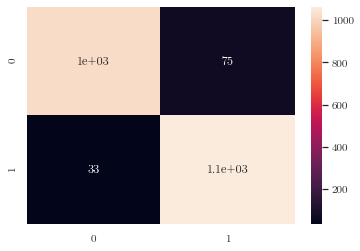

In [ ]:
# Verifica as métricas do modelo Spacy
# com o texto original

X_train, X_test, y_train, y_test = train_test_split(
    used_df,
    used_df["sentiment_binary"],
    test_size=0.2,
    random_state=random_state
)

nlp = spacy.load("models/spacy_cnn_raw_text.model")
spacy_model = SpacyModel(nlp=nlp, epochs=10)
# Executa as previsões
predictions = spacy_model.predict(X_test["text"])
import seaborn as sns
f = sns.heatmap(confusion_matrix(y_test,predictions), annot=True)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
# Desabilita a chamada dessa célula. 
# COMENTE A LINHA A SEGUIR PARA EXECUTAR ESTA CÉLULA
%%script false

# Treinamento do spacy com o texto processado



X_train, X_test, y_train, y_test = train_test_split(
  used_df,
  used_df["sentiment_binary"],
  test_size=0.2,
  random_state=random_state
)

# cria um modelo vazio
nlp = spacy.blank("en")
spacy_model = SpacyModel(nlp=nlp, epochs=10, use_gpu=True)
# treina o spacy com o texto processado
spacy_model.fit(X_train["clean_text"], y_train)

spacy_model.nlp.to_disk("models/spacy_cnn_clean_text.model")

              precision    recall  f1-score   support

           0       0.72      0.82      0.77      1095
           1       0.80      0.68      0.73      1095

    accuracy                           0.75      2190
   macro avg       0.76      0.75      0.75      2190
weighted avg       0.76      0.75      0.75      2190

0.7534246575342466


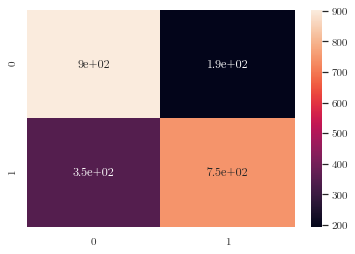

In [ ]:
# Verifica as métricas do modelo Spacy
# com o texto processado

X_train, X_test, y_train, y_test = train_test_split(
    used_df, 
    used_df["sentiment_binary"], 
    test_size=0.2, 
    random_state=random_state
)

nlp = spacy.load("models/spacy_cnn_clean_text.model")
spacy_model = SpacyModel(nlp=nlp, epochs=10)
# Executa as previsões
predictions = spacy_model.predict(X_test["clean_text"])
import seaborn as sns
f = sns.heatmap(confusion_matrix(y_test,predictions), annot=True)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
# Desabilita a chamada dessa célula. 
# COMENTE A LINHA A SEGUIR PARA EXECUTAR ESTA CÉLULA
%%script false


# Treinamento do spacy com as palavras reduzidas



X_train, X_test, y_train, y_test = train_test_split(
  used_df, 
  used_df["sentiment_binary"], 
  test_size=0.2, 
  random_state=random_state
)

# cria um modelo vazio
nlp = spacy.blank("en")
spacy_model = SpacyModel(nlp=nlp, epochs=10, use_gpu=True)
# treina o spacy com as palavras reduzidas
spacy_model.fit(X_train["important_words"], y_train)

spacy_model.nlp.to_disk("models/spacy_cnn_important_words.model")

              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1095
           1       0.74      0.70      0.72      1095

    accuracy                           0.73      2190
   macro avg       0.73      0.73      0.73      2190
weighted avg       0.73      0.73      0.73      2190

0.7264840182648402


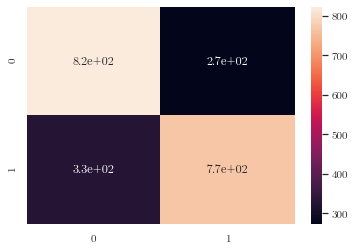

In [ ]:
# Verifica as métricas do modelo Spacy
# com as palavras reduzidas

X_train, X_test, y_train, y_test = train_test_split(
    used_df, 
    used_df["sentiment_binary"], 
    test_size=0.2, 
    random_state=random_state
)

nlp = spacy.load("models/spacy_cnn_important_words.model")
spacy_model = SpacyModel(nlp=nlp, epochs=10)
# Executa as previsões
predictions = spacy_model.predict(X_test["important_words"])
import seaborn as sns
f = sns.heatmap(confusion_matrix(y_test,predictions), annot=True)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

Foram treinadas 10 épocas a partir de um modelo spacy em branco e os resultados foram: 95,07% de acurácia para o texto original, 75,34% de acurácia para o texto processado e 72,65% de acurácia para palavras reduzidas. Isso mostra que o spacy foi capaz de trabalhar muito melhor com os textos originais, tirando vantangem de inferir a partir do contexto que cada palavra se insere, além de aprender também como os emojis influenciam o sentimento.

## 5.7. Transformers - Bert

Como último modelo, testou-se o BERT (Bidirectional Encoder Representations from Transformers), um modelo de aprendizado profundo (deep learning) do tipo “transformers”. Nos modelos do tipo “transformers”, é utilizado um mecanismo de atenção em conjunto com CNNs, como se, ao ler uma texto, focasse em uma palavra mas analisasse as outras, atribuindo pesos a elas e guardando as palavras importantes de forma a atribuir mais contexto ao processamento.

Como esse é modelo muito demorado para se treinar e que em geral com poucas épocas já apresenta um bom resultado, foram executadas apenas 3 épocas de treinamento e os demais parâmetros permaneceram com padrão utilizado pela biblioteca. Vale observar que no caso do BERT não foi utilizado um modelo em branco, mas realizado um treinamento de ajuste fino em cima do modelo “neuralmind/bert-large-portuguese-cased”, acessado pela biblioteca transformers em 09/04/2021.


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 18.6MB/s 
     |████████████████████████████████| 3.3MB 50.3MB/s 
     |████████████████████████████████| 870kB 44.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=65e46d48fa63061513e6edc2b4bdc6be1deb6ef5667bba5f5f0b46e4388e7998
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

import torch

# cria uma classe para o transformers com métodos parecidos aos usados no
# sklearn
class BertModel:
  def __init__(
      self, 
      # modelo padrão para separar texto em palavras
      tokenizer="neuralmind/bert-large-portuguese-cased", 
      # modelo pré-treinado base para treinar esse modelo
      transformers_model="neuralmind/bert-large-portuguese-cased"):
    self.transformers_model = transformers_model
    self.tokenizer = BertTokenizerFast.from_pretrained(tokenizer)
    self.model = BertForSequenceClassification.from_pretrained(
        transformers_model, 
        num_labels = 2, # Número de rótulos: 2, positivo (1) e negativo (0)
        output_attentions = False, 
        output_hidden_states = False,
    )

    # envia o modelo para a GPU
    self.model.to("cuda:0")
  
  # treina o modelo
  def fit(self, X, y):

    # separa em palavras, já no formato utilizado pelo transformers,
    # truncando o texto em no máximo 128 palavras
    train_encodings = self.tokenizer(
        X.tolist(), 
        truncation=True, 
        padding='max_length', 
        max_length=128
    )
    train_dataset = BertModel.Dataset(train_encodings, y.tolist())

    # define os argumentos de treinamento
    # foram utilizados os parâmetros padrão para o Bert
    training_args = TrainingArguments(
      output_dir='./results',         
      num_train_epochs=3, 
      per_device_train_batch_size=16,
      per_device_eval_batch_size=64, 
      warmup_steps=500,              
      weight_decay=0.01,             
      logging_dir='./logs',
    )

    # criar o objeto treinador do transformers
    trainer = Trainer(
      model=self.model,
      args=training_args,
      train_dataset=train_dataset
    )

    # treina o modelo
    trainer.train()

  # prevê o resultado
  def predict(self, X):
    y_pred = []
    for index, text in X.iteritems():

      # separa em palavras, já no formato utilizado pelo transformers
      inputs = self.tokenizer(
        [text], truncation=True, padding='max_length', max_length=128,
        return_tensors="pt"
      )

      # envia para a GPU
      inputs.to("cuda:0")
      # aplica o modelo
      outputs = self.model(**inputs)
      # recupera a predição e inclui na lista
      y_pred.append(int(outputs.logits.argmax(-1)[0]))
    return y_pred

  def save_model(self, location):
    self.model.save_pretrained(location)

  # classe auxiliar para preparação do dataset no torch
  class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels

    def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

    def __len__(self):
      return len(self.labels)




In [ ]:
# Desabilita a chamada dessa célula. 
# COMENTE A LINHA A SEGUIR PARA EXECUTAR ESTA CÉLULA
%%script false

# Treinamento do BERT com o texto original


bert_model = BertModel()

# treina o modelo para o texto original
bert_model.fit(X_train["text"], y_train)
bert_model.save_model("models/bert_raw_text.model")


              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1095
           1       0.97      0.98      0.98      1095

    accuracy                           0.98      2190
   macro avg       0.98      0.98      0.98      2190
weighted avg       0.98      0.98      0.98      2190

0.9776255707762557


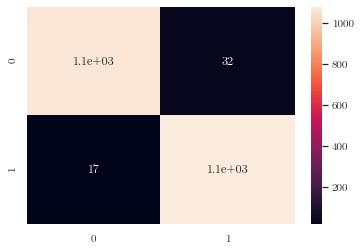

In [ ]:
# Verifica as métricas do modelo BERT
# com o texto original

bert_model = BertModel(transformers_model="models/bert_raw_text.model")

# Executa as previsões
predictions = bert_model.predict(X_test["text"])
import seaborn as sns
f = sns.heatmap(confusion_matrix(y_test,predictions), annot=True)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
# Desabilita a chamada dessa célula. 
# COMENTE A LINHA A SEGUIR PARA EXECUTAR ESTA CÉLULA
%%script false

# Treinamento do BERT com o texto processado

bert_model = BertModel()
# treina o modelo para o texto processado
bert_model.fit(X_train["clean_text"], y_train)
bert_model.save_model("models/bert_clean_text.model")

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1095
           1       0.85      0.83      0.84      1095

    accuracy                           0.84      2190
   macro avg       0.84      0.84      0.84      2190
weighted avg       0.84      0.84      0.84      2190

0.8392694063926941


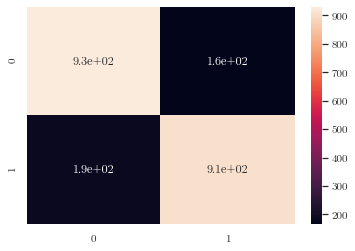

In [ ]:
# Verifica as métricas do modelo BERT
# com o texto processado

bert_model = BertModel(transformers_model="models/bert_clean_text.model")

# Executa as previsões
predictions = bert_model.predict(X_test["clean_text"])
import seaborn as sns
f = sns.heatmap(confusion_matrix(y_test,predictions), annot=True)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
# Desabilita a chamada dessa célula. 
# COMENTE A LINHA A SEGUIR PARA EXECUTAR ESTA CÉLULA
%%script false

# Treinamento do BERT com palavras reduzidas


bert_model = BertModel()
# treina o modelo para palavras reduzidas
bert_model.fit(X_train["important_words"], y_train)
bert_model.save_model("models/bert_important_words.model")

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1095
           1       0.75      0.74      0.74      1095

    accuracy                           0.75      2190
   macro avg       0.75      0.75      0.75      2190
weighted avg       0.75      0.75      0.75      2190

0.745662100456621


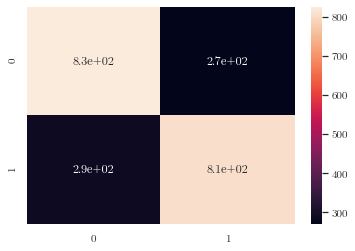

In [ ]:
# Verifica as métricas do modelo BERT
# com palavras reduzidas

bert_model = BertModel(transformers_model="models/bert_important_words.model")
predictions = bert_model.predict(X_test["important_words"])
import seaborn as sns
f = sns.heatmap(confusion_matrix(y_test,predictions), annot=True)
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

Para o BERT, obteve-se 97,76% de acurácia para o texto original, 83,93% para o texto processado e 74,57% para as palavras reduzidas.

# 6. Apresentação dos resultados

Este trabalho teve como proposta demonstrar a aplicabilidade de modelos de inteligência artificial para mensagens de texto enviadas a entidades governamentais, no caso específico, mensagens enviadas à Receita Federal do Brasil (RFB). Para isso se aproveitaram datasets que já classificavam os sentimentos de textos em português e se incrementou com a classificação de sentimentos de uma pequena parcela das mensagens enviadas à RFB.

Observou-se que o melhor modelo foi o BERT treinado em cima do texto original, tendo apresentado 97,76% de acurácia para o conjunto de datasets. Ao se aplicar somente aos “Tweets classificados RFB” presentes no dataset de teste, houve 85,55% de acurácia. 

Em geral, os modelos que utilizaram técnicas de aprendizado profundo (Spacy e BERT) apresentaram resultados muito superiores aos outros modelos que utilizaram vetores desordenados de palavras.


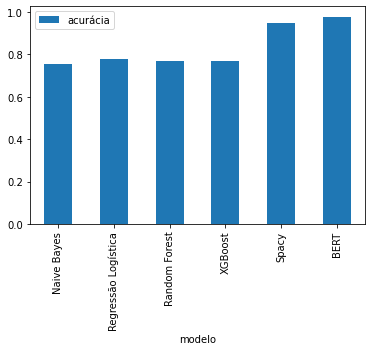

In [ ]:
# Gera gráfico comparativo da acurácia dos modelos

models = [
  {"modelo": "Naive Bayes", "acurácia": 0.7530},
  {"modelo": "Regressão Logística","acurácia": 0.7796},
  {"modelo": "Random Forest","acurácia": 0.7679},
  {"modelo": "XGBoost","acurácia": 0.7709},
  {"modelo": "Spacy","acurácia": 0.9507},
  {"modelo": "BERT","acurácia": 0.9776}
]

df = pd.DataFrame(models)
df.plot(kind="bar", x="modelo")

In [ ]:
# Executa as previsões somente sobre os dados do
# dataset "Tweets classificados RFB"

import seaborn as sns
bert_model = BertModel(transformers_model="models/bert_raw_text.model")
y = y_test[X_test["origin"] == "tweets_rfb"]
predictions = bert_model.predict(
    X_test[X_test["origin"] == "tweets_rfb"]["text"]
)

print(accuracy_score(y, predictions))
print(classification_report(y,predictions))


0.8554913294797688
              precision    recall  f1-score   support

           0       0.89      0.84      0.87        96
           1       0.82      0.87      0.84        77

    accuracy                           0.86       173
   macro avg       0.85      0.86      0.85       173
weighted avg       0.86      0.86      0.86       173



In [ ]:
# Guarda o resultado das previsões na coluna sentiment_binary
y_pred =  bert_model.predict(
    tweets_rfb_df["text"]
)
tweets_rfb_df["sentiment_binary"] = y_pred

In [ ]:
# Salva o resultado da aplicação do modelo aos tweets rfb
tweets_rfb_df.to_json("datasets/tweets_preditos_rfb.json")


Ao aplicar esse modelo aos “Tweets RFB” sem classificação conhecida, permitiu-se observar visualmente um adequado nível de acerto, como pode-se ver pela figura abaixo.


In [ ]:
with pd.option_context('display.max_colwidth', -1): 
  display(
      tweets_rfb_df[
        ["text", "sentiment_binary"]
      ].sample(10, random_state=random_state)
  )

,text,sentiment_binary
9056,@ReceitaFederal não estou conseguindo emitir guia de pagamento do esocial! O site de vocês está travado! Não é justo ter que pagar multa!,0
8827,@ReceitaFederal a brasilan actor three brasilian people and a child nter the earth at coma and the actor under the floor help,1
9271,"@ReceitaFederal colocar banner dizendo ser referência em gestão é fácil, difícil é atender um contribuinte sem ele esperar 1h25 min #RFfake",0
10012,@ReceitaFederal isso impossibilita de fazer login e prosseguir com a emissão necessária. alguém + passando por isso? favor verificar!,0
7933,@ReceitaFederal FEDERAL NO PORTO DE ITAGUAÍ APREENDE DEZ CONTÊINERES CONTENDO PRODUTOS CONTRAFEITOS #PortodeItaguaí\n\nhttps://t.co/tLKij7uvSa https://t.co/01rSz0zeN3,1
8118,@ReceitaFederal @FazendaGovBr Igual a dada a JBF?,0
6909,@ReceitaFederal \nOlá! Recebo pagamentos de uma empresa por lhes alugar um terreno. \nPor lei (IN-RFB 1.215/2011) o Informe de Rendimentos deveria estar disponivel em 28/02/2018. \nCobro isto deles desde 22/03/2018 estão postergando. \n\nVocês ajudam com isso? \n\n(Grato),0
6132,@ReceitaFederal https://t.co/JbapikvyAl,1
5585,@ReceitaFederal \nOs advogados do adelio entregarão suas declarações de rendimentos?\nQUEM PAGOU PARA MANDAR MATAR @jairbolsonaro ???????????????????????????????????????????????,0
7081,@ReceitaFederal Transmissão com erro: como se o prazo tivesse acabado.....,0


In [ ]:
# separa a data por campos de interesse para futuro agrupamento
tweets_rfb_df["year"] = tweets_rfb_df["created_at"].dt.year
tweets_rfb_df["month"] = tweets_rfb_df["created_at"].dt.month
tweets_rfb_df["day"] = tweets_rfb_df["created_at"].dt.date
tweets_rfb_df["week_day"] = tweets_rfb_df["created_at"].dt.strftime('%a')

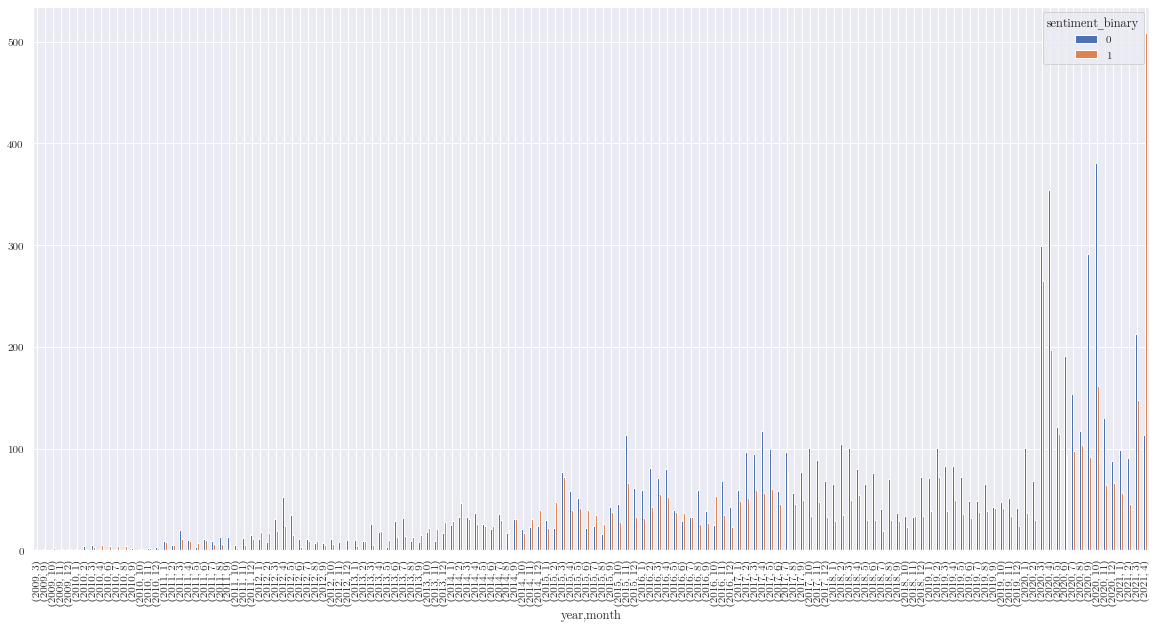

In [ ]:
# gera gráfico agrupado por mê/ano para o dataset
# Tweets RFB
tweets_rfb_df.groupby(
  ['year', 'month', 'sentiment_binary']
).size().unstack(level=2).plot(kind = 'bar', figsize=(20,10))

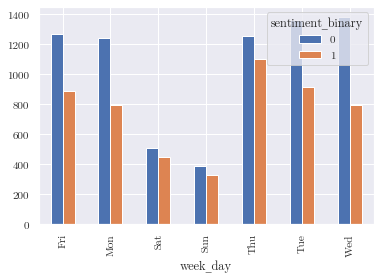

In [ ]:
# gera gráfico agrupado por dia da semana para o dataset
# Tweets RFB
tweets_rfb_df.groupby(
    ['week_day', 'sentiment_binary']
).size().unstack(level=1).plot(kind = 'bar')

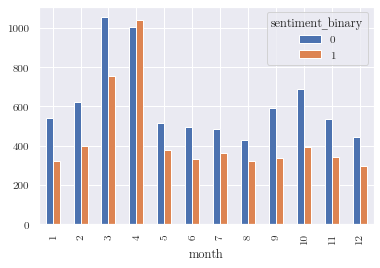

In [ ]:
tweets_rfb_df.groupby(
    ['month', 'sentiment_binary']
).size().unstack(level=1).plot(kind = 'bar')

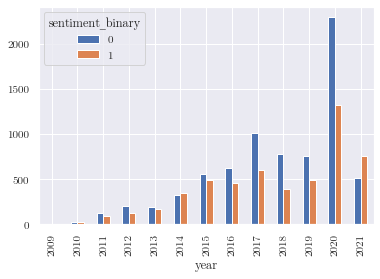

In [ ]:
tweets_rfb_df.groupby(
    ['year', 'sentiment_binary']
).size().unstack(level=1).plot(kind = 'bar' )

Na análise da distribuição desses sentimentos no tempo, verificou-se que a discrepância entre sentimentos negativos e positivos continua alta na sexta-feira (apesar da maior diferença na quarta-feira) e menor no sábado (dia em que houve maioria de sentimentos positivos no dataset classificado). No gráfico anual, observou-se que, para o ano de 2021, os sentimentos positivos são em número superior aos negativos, similar ao dataset classificado.

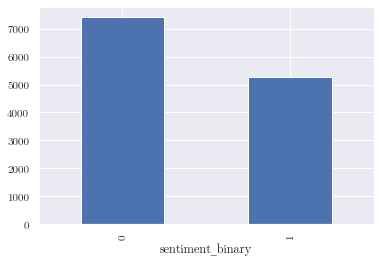

In [ ]:
tweets_rfb_df.value_counts("sentiment_binary").plot(kind = 'bar')

Com a aplicação do modelo, observou-se que a quantidade de sentimentos negativos em geral é superior à de sentimentos positivos, o que mostra uma tendência de se haver sentimentos negativos nesse dataset.

Assim, pela excelente acurácia geral do modelo e pela boa acurácia dentro do nicho de estudo, pode-se dizer que o modelo é considerado satisfatório, podendo ser melhorado em trabalhos posteriores que incluam mais dados do setor com a classificação de sentimentos já realizada. 

A partir desse modelo já é possível realizar outros estudos com a análise dos sentimentos. Entre as possibilidades de trabalhos futuros destacam-se os seguintes: verificar correlações entre campanhas ou ações e variações na percepção geral da imagem da instituição; classificação das mensagens por tópicos e verificação da percepção pública de determinado serviço; avaliação da probabilidade de problemas em serviços com base em densidade de mensagens com sentimentos negativos relacionados a determinado serviço ou à imagem geral da instituição, dentre outros.
